# The required packages.

In [34]:
import import_ipynb
import copy
import time
import random
import numpy as np
import pandas as pd # for batch data loading, in generating sampled dataset
from rtree import index # this package is only used for constructing Rtree filter
from numpy import genfromtxt
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D

# The Utilities Classes

In [35]:
class SplitContext:
    '''
    to maintain the split information
    split_type:
    0 = candidate cut
    1 = bounding split
    2 = dual-bounding split
    3 = new bounding split
    '''
    def __init__(self, split_type, split_dimension, split_value):
        self.split_type = split_type
        self.split_dimension = split_dimension
        self.split_value = split_value
        
        self.sub_partitions = []
        self.split_gain = 0

In [36]:
class QueryMBR:
    '''
    the MBR that bound overlapped queries
    '''
    def __init__(self, boundary, added_as_fist_query = True):
        self.num_dims = len(boundary) / 2
        self.boundary = boundary
        self.num_query = 1
        self.queries = []
        self.bound_size = None # number of records this MBR overlaps
        self.total_query_result_size = None # total query results size of all the queries inside this MBR
        self.query_result_size = [] # record each query's result size
        self.is_extended = False
        self.ill_extended = False
        if added_as_fist_query:
            self.queries = [boundary]
        
    def check_condition3(self, data_threshold):
        '''
        check whether this MBR satisfy the new bounding split condition 3:
        1. every query size > BP - b
        2. total_query_result_size + b > bound_size * num_query
        '''
        for size in self.query_result_size:
            if size <= self.bound_size - data_threshold:
                return False
        
        if self.total_query_result_size + data_threshold <= self.bound_size * self.num_query:
            return False
        
        return True

# The PartitionNode Class.
It maintains the meta infos of a partition.
It also provides support functions related to split and query overlap checking.

In [207]:
class PartitionNode:
    '''
    A partition node, including both the internal and leaf nodes in the partition tree
    '''
    def __init__(self, num_dims = 0, boundary = [], nid = None, pid = None, is_irregular_shape_parent = False,
                 is_irregular_shape = False, num_children = 0, children_ids = [], is_leaf = True, node_size = 0):
        
        # print("Initialize PartitionTree Root: num_dims",num_dims,"boundary:",boundary,"children_ids:",children_ids)
        self.num_dims = num_dims # number of dimensions
        # the domain, [l1,l2,..,ln, u1,u2,..,un,], for irregular shape partition, one need to exempt its siblings
        self.boundary = boundary # I think the lower side should be inclusive and the upper side should be exclusive?
        self.nid = nid # node id
        self.pid = pid # parent id
        self.is_irregular_shape_parent = is_irregular_shape_parent # whether the [last] child is an irregular shape partition
        self.is_irregular_shape = is_irregular_shape # an irregular shape partition cannot be further split, and it must be a leaf node
        self.num_children = num_children # number of children, should be 0, 2, or 3
        self.children_ids = children_ids # if it's the irregular shape parent, then the last child should be the irregular partition
        self.is_leaf = is_leaf
        self.node_size = node_size # number of records in this partition
        
        # the following attributes will not be serialized
        self.dataset = None # only used in partition algorithms, temporary, should consist records that within this partition
        self.queryset = None # only used in partition algorithms, temporary, should consist queries that overlap this partition
        self.partitionable = True # only used in partition algorithms
        self.query_MBRs = None # only used in partition algorithms, temporary
        self.split_type = None # only used in partition algorithms
        
        # Rtree filters
        self.rtree_filters = None # a collection of MBRs, in the shape of boundary, used to indicate the data distribution
        
        # beam search
        self.depth = 0 # only used in beam search, root node depth is 0
        
    def is_overlap(self, query):
        '''
        query is in plain form, i.e., [l1,l2,...,ln, u1,u2,...,un]
        !query dimension should match the partition dimensions! i.e., all projected or all not projected
        return 0 if no overlap
        return 1 if overlap
        return 2 if inside
        '''
        if len(query) != 2 * self.num_dims:
            return -1 # error
        
        overlap_flag = True
        inside_flag = True
        
        for i in range(self.num_dims):
            if query[i] >= self.boundary[self.num_dims + i] or query[self.num_dims + i] <= self.boundary[i]:
                overlap_flag = False
                inside_flag = False
                return 0
            elif query[i] < self.boundary[i] or query[self.num_dims + i] > self.boundary[self.num_dims + i]:
                inside_flag = False
                
        if inside_flag:
            return 2
        elif overlap_flag:
            return 1
        else:
            return 0
    
    def is_overlap_np(self, query):
        '''
        the numpy version of the is_overlap function
        the query here and boundary class attribute should in the form of numpy array
        '''
        if all((boundary[0:self.num_dims] > query[self.num_dims:]) | (boundary[self.num_dims:] <= query[0:self.num_dims])):
            return 0 # no overlap
        elif all((boundary[0:self.num_dims] >= query[0:self.num_dims]) & (boundary[self.num_dims:] <= query[self.num_dims:])):
            return 2 # inside
        else:
            return 1 # overlap
    
    def get_candidate_cuts(self, extended = False):
        '''
        get the candidate cut positions
        if extended is set to True, also add medians from all dimensions
        '''
        candidate_cut_pos = []
        for query in self.queryset:
            for dim in range(self.num_dims):
                # check if the cut position is inside the partition, as the queryset are queries overlap this partition
                if query[dim] >= self.boundary[dim] and query[dim] <= self.boundary[self.num_dims+dim]:
                    candidate_cut_pos.append((dim, query[dim]))
                if query[self.num_dims+dim] >= self.boundary[dim] and query[self.num_dims+dim] <= self.boundary[self.num_dims+dim]:
                    candidate_cut_pos.append((dim, query[self.num_dims+dim]))
        
        if extended:
            for dim in range(self.num_dims):
                split_value = np.median(self.dataset[:,dim])
                candidate_cut_pos.append((dim, split_value))
        
        return candidate_cut_pos
    
    def if_split(self, split_dim, split_value, data_threshold, test = False): # rename: if_split_get_gain
        '''
        return the skip gain and children partition size if split a node from a given split dimension and split value
        '''
        #print("current_node.nid:", current_node.nid)
        #print("current_node.is_leaf:", current_node.is_leaf)
        #print("current_node.dataset is None:", current_node.dataset is None)
        sub_dataset1_size = np.count_nonzero(self.dataset[:,split_dim] < split_value) # process time: 0.007
        sub_dataset2_size = self.node_size - sub_dataset1_size

        if sub_dataset1_size < data_threshold or sub_dataset2_size < data_threshold:
            return False, 0, sub_dataset1_size, sub_dataset2_size
        
        left_part, right_part, mid_part = self.split_queryset(split_dim, split_value)
        num_overlap_child1 = len(left_part) + len(mid_part)
        num_overlap_child2 = len(right_part) + len(mid_part)
        
        if test:
            print("num left part:",len(left_part), "num right part:",len(right_part), "num mid part:",len(mid_part))
            print("left part:", left_part, "right part:", right_part, "mid part:",mid_part)
        
        # temp_child_node1, temp_child_node2 = self.__if_split_get_child(split_dim, split_value)
        skip_gain = len(self.queryset)*self.node_size - num_overlap_child1*sub_dataset1_size - num_overlap_child2*sub_dataset2_size
        return True, skip_gain, sub_dataset1_size, sub_dataset2_size
    
    def if_bounding_split(self, data_threshold, approximate = False, force_extend = False):
        '''
        # the split node is assumed to be >= 2b
        approximate: whether use approximation (even distribution) to find the number of records within a partition
        force_extend: whether extend the bounding partition to make its size greater than data_threshold, if possible
        return availability, skip gain, and the (possible extended) bound
        '''
        max_bound = self.__max_bound(self.queryset)
        bound_size = self.query_result_size(max_bound, approximate)
        if bound_size is None:
            return False, None, None
        
        extended_bound = copy.deepcopy(max_bound)
        if bound_size < data_threshold: # assume the partition is >= 2b, then we must be able to find the valid extension
            if force_extend:
                side = 0
                for dim in range(self.num_dims):
                    valid, extended_bound, bound_size = self.__try_extend(extended_bound, dim, 0, data_threshold) # lower side
                    if valid:
                        break
                    valid, extended_bound, bound_size = self.__try_extend(extended_bound, dim, 1, data_threshold) # upper side
                    if valid:
                        break
            else:
                return False, None, None   
        
        remaining_size = self.node_size - bound_size
        if remaining_size < data_threshold:
            return False, None, None
        cost_before_split = len(self.queryset) * self.node_size
        cost_bound_split = len(self.queryset) * bound_size
        skip_gain = cost_before_split - cost_bound_split
        
        if force_extend:
            return True, skip_gain, extended_bound
        else:
            return True, skip_gain, max_bound # TODO: should we also return the extended bound? 

    def if_new_bounding_split(self, data_threshold, approximate = False, force_extend = True):
        '''
        In this version, we try to generate a collection of MBR partitions if every MBR satisfy:
        1. its size <= b; or
        2. it contains only 1 query; or
        3. |Q|*Core + b > its size * |Q|
        
        OR (if the above failed) a single bounding partition and an irregular shape partition as the old version
        '''
        if self.query_MBRs is None:
            return
        
        check_valid = True
        extended_flag = False
        
        # simple pruning
        if len(self.query_MBRs) * data_threshold > self.node_size:
            check_valid = False
        else:
            for MBR in self.query_MBRs:
                if MBR.bound_size <= data_threshold or MBR.num_query == 1 or MBR.check_condition3(data_threshold):
                    pass
                else:
                    check_valid = False
                    break
        
        if check_valid:
            # try extend the MBRs to satisfy b, and check whether the extended MBRs overlap with others
            for MBR in self.query_MBRs:
                if MBR.bound_size < data_threshold:
                    MBR.boundary, MBR.bound_size = self.extend_bound(MBR.boundary, data_threshold)
                    MBR.is_extended = True
                    if MBR.bound_size > 2 * data_threshold:
                        MBR.ill_extended = True # if there are too many same key records
                if MBR.is_extended:
                    extended_flag = True # also for historical extended MBRs !!!
                    
            
        # check if the extended MBRs overlaps each other
        if extended_flag and len(self.query_MBRs) > 1:
            for i in range(len(self.query_MBRs) - 1):
                for j in range(i+1, len(self.query_MBRs)):
                    if self.query_MBRs[i].ill_extended or self.query_MBRs[j].ill_extended or self.__is_overlap(self.query_MBRs[i].boundary, self.query_MBRs[j].boundary):
                        #print("partition",self.nid,"found overlap of extended MBRs:", self.query_MBRs[i].boundary, self.query_MBRs[j].boundary)
                        check_valid = False
                        break
                if not check_valid:
                    break
        
        if len(self.query_MBRs) == 1 and self.query_MBRs[0].ill_extended: # in case there is only 1 MBR
            check_valid = False
        
        # check the remaining partition size, if it's not greater than b, return false
        remaining_size = self.node_size
        for MBR in self.query_MBRs:
            remaining_size -= MBR.bound_size
        if remaining_size < data_threshold:
            check_valid = False
        
        # if the above failed
        if check_valid:
            return True # since this is the optimal, we don't need to return skip
        else:
            # do we need to restore the MBRs?
            # NO, when split cross a MBR, it will be rebuilt on both side
            # In other cases, the extended MBR doesn't matter
            return False  
    
    def if_dual_bounding_split(self, split_dim, split_value, data_threshold, approximate = False):
        '''
        check whether it's available to perform dual bounding split
        return availability and skip gain
        '''
        # split queriese first
        left_part, right_part, mid_part = self.split_queryset(split_dim, split_value)
        max_bound_left = self.__max_bound(left_part)
        max_bound_right = self.__max_bound(right_part)
        
        # Should we only consider the case when left and right cannot be further split? i.e., [b,2b)
        # this check logic is given in the PartitionAlgorithm, not here, as the split action should be general
        naive_left_size = np.count_nonzero(self.dataset[:,split_dim] < split_value)
        naive_right_size = self.node_size - naive_left_size
        
        # get (irregular-shape) sub-partition size
        left_size = self.query_result_size(max_bound_left, approximate)
        if left_size is None: # there is no query within the left 
            left_size = naive_left_size # use the whole left part as its size
        if left_size < data_threshold:
            return False, None
        right_size = self.query_result_size(max_bound_right, approximate)
        if right_size is None: # there is no query within the right
            right_size = naive_right_size # use the whole right part as its size
        if right_size < data_threshold:
            return False, None
        remaining_size = self.node_size - left_size - right_size
        if remaining_size < data_threshold:
            return False, None
        
        # check cost
        cost_before_split = len(self.queryset) * self.node_size
        cost_dual_split = len(left_part) * left_size + len(right_part) * right_size + len(mid_part) * remaining_size
        for query in mid_part:
            # if it overlap left bounding box
            if max_bound_left is None or self.__is_overlap(max_bound_left, query) > 0:
                cost_dual_split += left_size
            # if it overlap right bounding box
            if max_bound_right is None or self.__is_overlap(max_bound_right, query) > 0:
                cost_dual_split += right_size
        skip_gain = cost_before_split - cost_dual_split
        return True, skip_gain
        
    def num_query_crossed(self, split_dim, split_value):
        '''
        similar to the split_queryset function, but just return how many queries the intended split will cross
        '''
        count = 0
        if self.queryset is not None:
            for query in self.queryset:
                if query[split_dim] < split_value and query[self.num_dims + split_dim] > split_value:
                    count += 1
            return count
        return None
    
    def split_queryset(self, split_dim, split_value):
        '''
        split the queryset into 3 parts:
        the left part, the right part, and those cross the split value
        '''
        if self.queryset is not None:
            left_part = []
            right_part = []
            mid_part = []
            for query in self.queryset:
                if query[split_dim] >= split_value:
                    right_part.append(query)
                elif query[self.num_dims + split_dim] <= split_value:
                    left_part.append(query)
                elif query[split_dim] < split_value and query[self.num_dims + split_dim] > split_value:
                    mid_part.append(query)
            return left_part, right_part, mid_part
    
    def query_result_size(self, query, approximate = False):
        '''
        get the query result's size on this node
        the approximate parameter is set to True, the use even distribution to approximate
        '''
        if query is None:
            return None
        
        result_size = 0
        if approximate:
            query_volume = 1
            volume = 1
            for d in range(self.num_dims):
                query_volume *= query[self.num_dims + d] - query[d]
                volume *= self.boundary[self.num_dims + d] - self.boundary[d]

            result_size = int(query_volume / volume * self.node_size)
        else:
            constraints = []
            for d in range(self.num_dims):
                constraint_L = dataset[:,d] >= query[d]
                constraint_U = dataset[:,d] <= query[self.num_dims + d]
                constraints.append(constraint_L)
                constraints.append(constraint_U)
            constraint = np.all(constraints, axis=0)
            result_size = np.count_nonzero(constraint)
        return result_size
    
    def split_query_MBRs(self, split_dim, split_value):
        if self.query_MBRs is not None:
            left_part = [] # totally in left
            right_part = [] # totally in right
            mid_part = []
            for MBR in self.query_MBRs:
                if MBR.boundary[split_dim] >= split_value:
                    right_part.append(MBR)
                elif MBR.boundary[self.num_dims + split_dim] <= split_value:
                    left_part.append(MBR)
                elif MBR.boundary[split_dim] < split_value and MBR.boundary[self.num_dims + split_dim] > split_value:
                    mid_part.append(MBR)
                    
            # process each mid_part MBR
            overlap_left_part_queries = []
            overlap_right_part_queries = []
            for MBR in mid_part:
                for query in MBR.queries:
                    if query[split_dim] < split_value:
                        overlap_left_part_queries.append(query)
                    if query[self.num_dims + split_dim] > split_value:
                        overlap_right_part_queries.append(query)
                
            # generate MBRs for both part. Notice we cannot simply adjust the shape using original MBRs
            mid_part_left_MBRs = self.generate_query_MBRs(overlap_left_part_queries)
            mid_part_right_MBRs = self.generate_query_MBRs(overlap_right_part_queries)
            
            left_part += mid_part_left_MBRs
            right_part += mid_part_right_MBRs
            
            return left_part, right_part
    
    def generate_query_MBRs(self, queryset = None):
        '''
        bound the overlapped queries in this partition into MBRs
        the MBRs will only contains the part inside this partition
        '''
        if queryset is None:
            queryset = self.queryset
        
        if len(queryset) == 0:
            return []
        
        query_MBRs = []
        for query in queryset:
            query_MBRs.append(QueryMBR(query, True))
            
        #print("before merged, number of query MBRs:", len(query_MBRs))
        
        while len(query_MBRs) >= 2:
            
            new_query_MBRs = []
            merged_qids = []

            for i in range(len(query_MBRs)-1):
                new_MBR = copy.deepcopy(query_MBRs[i])
                
                if i in merged_qids:
                    continue
                
                for j in range(i+1, len(query_MBRs)):
                    if j in merged_qids:
                        continue
                    if self.__is_overlap(query_MBRs[i].boundary, query_MBRs[j].boundary):
                        #print("merge:",i,j,query_MBRs[i].boundary,query_MBRs[j].boundary)
                        new_MBR = self.__merge_2MBRs(new_MBR, query_MBRs[j])
                        merged_qids.append(j)
                
                new_query_MBRs.append(new_MBR)
                #print("for iteration",i, "current new_query_MBRs size:",len(new_query_MBRs))
            
            if len(query_MBRs)-1 not in merged_qids:
                new_query_MBRs.append(query_MBRs[-1])
            
            if len(query_MBRs) == len(new_query_MBRs):
                break
            else:
                query_MBRs = copy.deepcopy(new_query_MBRs)
        
        #print("after merged, number of query MBRs:", len(query_MBRs))
        
        # bound each query MBRs by its partition boundary, and calculate the result size
        for MBR in query_MBRs:
            MBR.boundary = self.__max_bound_single(MBR.boundary)
            MBR.bound_size = self.query_result_size(MBR.boundary)
            for query in MBR.queries:
                MBR.query_result_size.append(self.query_result_size(query))
            MBR.total_query_result_size = sum(MBR.query_result_size)
        
        self.query_MBRs = query_MBRs
        
        return query_MBRs
    
    def extend_bound(self, bound, data_threshold, print_info = False):
        '''
        extend a bound to be at least b, assume the bound is within the partition boundary
        '''
        side = 0
        for dim in [2,0,1,4,3,5,6]: #[0,1,4,3,5,6,2]: #range(self.num_dims): # reranged by distinct values
            if dim+1 > self.num_dims:
                continue
            
            valid, bound, bound_size = self.__try_extend(bound, dim, 0, data_threshold, print_info) # lower side
            if print_info:
                print("dim:",dim,"current bound:",bound,valid,bound_size)
            if valid:
                break
            valid, bound, bound_size = self.__try_extend(bound, dim, 1, data_threshold, print_info) # upper side
            if print_info:
                print("dim:",dim,"current bound:",bound,valid,bound_size)
            if valid:
                break
        return bound, bound_size
    
    # = = = = = internal functions = = = = =
    
    def __try_extend(self, current_bound, try_dim, side, data_threshold, print_info = False):
        '''
        side = 0: lower side
        side = 1: upper side
        return whether this extend has made bound greater than b, current extended bound, and the size
        '''
        # first try the extreme case
        dim = try_dim
        if side == 1:
            dim += self.num_dims
            
        extended_bound = copy.deepcopy(current_bound)
        extended_bound[dim] = self.boundary[dim]
        
        bound_size = self.query_result_size(extended_bound, approximate = False)
        if bound_size < data_threshold:
            return False, extended_bound, bound_size
        
        # binary search in this extend direction
        L, U = None, None
        if side == 0:
            L, U = self.boundary[dim], current_bound[dim]
        else:
            L, U = current_bound[dim], self.boundary[dim]
        
        if print_info:
            print("L,U:",L,U)
        
        loop_count = 0
        while L < U and loop_count < 30:
            mid = (L+U)/2
            extended_bound[dim] = mid
            bound_size = self.query_result_size(extended_bound, approximate = False)
            if bound_size < data_threshold:
                    L = mid
            elif bound_size > data_threshold:
                    U = mid
                    if U - L < 0.00001:
                        break
            else:
                break
            if print_info:
                print("loop,L:",L,"U:",U,"mid:",mid,"extended_bound:",extended_bound,"size:",bound_size)
            loop_count += 1
            
        return bound_size >= data_threshold, extended_bound, bound_size
        
    
    def __is_overlap(self, boundary, query):
        '''
        the difference between this function and the public is_overlap function lies in the boundary parameter
        '''
        if len(query) != 2 * self.num_dims:
            return -1 # error
        
        overlap_flag = True
        inside_flag = True
        
        for i in range(self.num_dims):
            if query[i] >= boundary[self.num_dims + i] or query[self.num_dims + i] <= boundary[i]:
                overlap_flag = False
                inside_flag = False
                return 0
            elif query[i] < boundary[i] or query[self.num_dims + i] > boundary[self.num_dims + i]:
                inside_flag = False
                
        if inside_flag:
            return 2
        elif overlap_flag:
            return 1
        else:
            return 0
        
    def __merge_2MBRs(self, MBR1, MBR2):
        '''
        merge 2 MBRs into 1 (the first one)
        in this step we do not consider whether the merged MBR exceeds the current partition
        '''
        for i in range(self.num_dims):
            MBR1.boundary[i] = min(MBR1.boundary[i], MBR2.boundary[i])
            MBR1.boundary[self.num_dims + i] = max(MBR1.boundary[self.num_dims + i], MBR2.boundary[self.num_dims + i])
        
        MBR1.queries += MBR2.queries
        MBR1.num_query += MBR2.num_query
        return MBR1
    
    def __max_bound(self, queryset):
        '''
        bound the queries by their maximum bounding rectangle !NOTE it is for a collection of queries!!!
        then constraint the MBR by the node's boundary!
        
        the return bound is in the same form as boundary
        '''
        if len(queryset) == 0:
            return None
        #if len(queryset) == 1:
        #    pass, I don't think there will be shape issue here
        
        max_bound_L = np.amin(np.array(queryset)[:,0:self.num_dims],axis=0).tolist()
        # bound the lower side with the boundary's lower side
        max_bound_L = np.amax(np.array([max_bound_L, self.boundary[0:self.num_dims]]),axis=0).tolist()
        
        max_bound_U = np.amax(np.array(queryset)[:,self.num_dims:],axis=0).tolist()
        # bound the upper side with the boundary's upper side
        max_bound_U = np.amin(np.array([max_bound_U, self.boundary[self.num_dims:]]),axis=0).tolist()
        
        max_bound = max_bound_L + max_bound_U # concat
        return max_bound
    
    def __max_bound_single(self, query):
        '''
        bound anything in the shape of query by the current partition boundary
        '''
        for i in range(self.num_dims):
            query[i] = max(query[i], self.boundary[i])
            query[self.num_dims + i] = min(query[self.num_dims + i], self.boundary[self.num_dims + i])
        return query
        
    
    def __if_split_get_child(self, split_dim, split_value): # should I rename this to if_split_get_child
        '''
        return 2 child nodes if a split take place on given dimension with given value
        This function is only used to simplify the skip calculation process, it does not really split the node
        '''
        boundary1 = self.boundary.copy()
        boundary1[split_dim + self.num_dims] = split_value
        boundary2 = self.boundary.copy()
        boundary2[split_dim] = split_value
        child_node1 = PartitionNode(self.num_dims, boundary1)
        child_node2 = PartitionNode(self.num_dims, boundary2)
        return child_node1, child_node2

# The PartitionTree Class.
It maintain the structure of the whole partition process, including intermediate nodes and the final leaf partitions.
It also provides functions to maintain, serialize, and query the tree.

In [38]:
 class PartitionTree:
        '''
        The data structure that represent the partition layout, which also maintain the parent, children relation info
        Designed to provide efficient online query and serialized ability
        
        The node data structure could be checked from the PartitionNode class
        
        '''   
        def __init__(self, num_dims = 0, boundary = []):
            
            # the node id of root should be 0, its pid should be -1
            # note this initialization does not need dataset and does not set node size!

            self.pt_root = PartitionNode(num_dims, boundary, nid = 0, pid = -1, is_irregular_shape_parent = False, 
                                         is_irregular_shape = False, num_children = 0, children_ids = [], is_leaf = True, node_size = 0)
            self.nid_node_dict = {0: self.pt_root} # node id to node dictionary
            self.node_count = 1 # the root node
        
        # = = = = = public functions (API) = = = = =
        
        def save_tree(self, path):
            node_list = self.__generate_node_list(self.pt_root) # do we really need this step?
            serialized_node_list = self.__serialize(node_list)
            np.savetxt(path, serialized_node_list, delimiter=',')
            return serialized_node_list
            
        def load_tree(self, path):
            serialized_node_list = genfromtxt(path, delimiter=',')
            self.__build_tree_from_serialized_node_list(serialized_node_list)
        
        def query_single(self, query, using_rtree_filter = False):
            '''
            query is in plain form, i.e., [l1,l2,...,ln, u1,u2,...,un]
            return the overlapped leaf partitions ids!
            '''
            partition_ids = self.__find_overlapped_partition(self.pt_root, query, using_rtree_filter)
            return partition_ids
        
        def query_batch(self, queries):
            '''
            to be implemented
            '''
            pass
        
        def get_queryset_cost(self, queries):
            '''
            return the cost array directly
            '''
            costs = []
            for query in queries:
                overlapped_leaf_ids = self.query_single(query)
                cost = 0
                for nid in overlapped_leaf_ids:
                    cost += self.nid_node_dict[nid].node_size
                costs.append(cost)
            return costs
        
        def evaluate_query_cost(self, queries, print_result = False, using_rtree_filter = False):
            '''
            get the logical IOs of the queris
            return the average query cost
            '''
            total_cost = 0
            case = 0
            total_overlap_ids = {}
            case_cost = {}
            
            for query in queries:
                cost = 0
                overlapped_leaf_ids = self.query_single(query, using_rtree_filter)
                total_overlap_ids[case] = overlapped_leaf_ids
                for nid in overlapped_leaf_ids:
                    cost += self.nid_node_dict[nid].node_size
                total_cost += cost
                case_cost[case] = cost
                case += 1
            
            if print_result:
                print("Total logical IOs:", total_cost)
                print("Average logical IOs:", total_cost // len(queries))
                for case, ids in total_overlap_ids.items():
                    print("query",case, ids, "cost:", case_cost[case])
            
            return total_cost // len(queries)
        
        def add_node(self, parent_id, child_node):
            child_node.nid = self.node_count
            self.node_count += 1
            
            child_node.pid = parent_id
            self.nid_node_dict[child_node.nid] = child_node
            
            child_node.depth = self.nid_node_dict[parent_id].depth + 1
            
            self.nid_node_dict[parent_id].children_ids.append(child_node.nid)
            self.nid_node_dict[parent_id].num_children += 1
            self.nid_node_dict[parent_id].is_leaf = False
        
        
        def apply_split(self, parent_nid, split_dim, split_value, split_type = 0, extended_bound = None, approximate = False,
                        pretend = False):
            '''
            split_type = 0: split a node into 2 sub-nodes by a given dimension and value
            split_type = 1: split a node by bounding split (will create an irregular shape partition)
            split_type = 2: split a node by daul-bounding split (will create an irregular shape partition)
            
            extended_bound is only used in split type 1
            approximate: used for measure query result size
            pretend: if pretend is True, return the split result, but do not apply this split
            '''
            parent_node = self.nid_node_dict[parent_nid]
            if pretend:
                parent_node = copy.deepcopy(self.nid_node_dict[parent_nid])
            
            child_node1, child_node2 = None, None
            
            if split_type == 0:
            
                # create sub nodes
                child_node1 = copy.deepcopy(parent_node)
                child_node1.boundary[split_dim + child_node1.num_dims] = split_value
                child_node1.children_ids = []

                child_node2 = copy.deepcopy(parent_node)
                child_node2.boundary[split_dim] = split_value
                child_node2.children_ids = []
                
                if parent_node.query_MBRs is not None:
                    MBRs1, MBRs2 = parent_node.split_query_MBRs(split_dim, split_value)
                    child_node1.query_MBRs = MBRs1
                    child_node2.query_MBRs = MBRs2
                    
                # if parent_node.dataset != None: # The truth value of an array with more than one element is ambiguous.
                # https://stackoverflow.com/questions/36783921/valueerror-when-checking-if-variable-is-none-or-numpy-array
                if parent_node.dataset is not None:
                    child_node1.dataset = parent_node.dataset[parent_node.dataset[:,split_dim] < split_value]
                    child_node1.node_size = len(child_node1.dataset)
                    child_node2.dataset = parent_node.dataset[parent_node.dataset[:,split_dim] >= split_value]
                    child_node2.node_size = len(child_node2.dataset)

                if parent_node.queryset is not None:
                    left_part, right_part, mid_part = parent_node.split_queryset(split_dim, split_value)
                    child_node1.queryset = left_part + mid_part
                    child_node2.queryset = right_part + mid_part

                # update current node
                if not pretend:
                    self.add_node(parent_nid, child_node1)
                    self.add_node(parent_nid, child_node2)
                    self.nid_node_dict[parent_nid].split_type = "candidate cut"
            
            elif split_type == 1: # must reach leaf node, hence no need to maintain dataset and queryset any more
                
                child_node1 = copy.deepcopy(parent_node) # the bounding partition
                child_node2 = copy.deepcopy(parent_node) # the remaining partition, i.e., irregular shape
                
                child_node1.is_leaf = True
                child_node2.is_leaf = True
                
                child_node1.children_ids = []
                child_node2.children_ids = []
                
                max_bound = None
                if extended_bound is not None:
                    max_bound = extended_bound
                else:
                    max_bound = parent_node._PartitionNode__max_bound(parent_node.queryset)
                child_node1.boundary = max_bound
                child_node2.is_irregular_shape = True
                
                bound_size = parent_node.query_result_size(max_bound, approximate = False)
                remaining_size = parent_node.node_size - bound_size           
                child_node1.node_size = bound_size
                child_node2.node_size = remaining_size
                
                child_node1.partitionable = False
                child_node2.partitionable = False
                
                if not pretend:
                    self.add_node(parent_nid, child_node1)
                    self.add_node(parent_nid, child_node2)
                    self.nid_node_dict[parent_nid].is_irregular_shape_parent = True
                    self.nid_node_dict[parent_nid].split_type = "sole-bounding split"
            
            elif split_type == 2: # must reach leaf node, hence no need to maintain dataset and queryset any more
                
                child_node1 = copy.deepcopy(parent_node) # the bounding partition 1
                child_node2 = copy.deepcopy(parent_node) # the bounding partition 2
                child_node3 = copy.deepcopy(parent_node) # the remaining partition, i.e., irregular shape
                
                child_node1.is_leaf = True
                child_node2.is_leaf = True
                child_node3.is_leaf = True
                
                child_node1.children_ids = []
                child_node2.children_ids = []
                child_node3.children_ids = []
                
                left_part, right_part, mid_part = parent_node.split_queryset(split_dim, split_value)
                max_bound_1 = parent_node._PartitionNode__max_bound(left_part)
                max_bound_2 = parent_node._PartitionNode__max_bound(right_part)
                
                child_node1.boundary = max_bound_1
                child_node2.boundary = max_bound_2
                child_node3.is_irregular_shape = True          
                
                # Should we only consider the case when left and right cannot be further split? i.e., [b,2b)
                # this check logic is given in the PartitionAlgorithm, not here, as the split action should be general
                naive_left_size = np.count_nonzero(parent_node.dataset[:,split_dim] < split_value)
                naive_right_size = parent_node.node_size - naive_left_size

                # get (irregular-shape) sub-partition size
                bound_size_1 = parent_node.query_result_size(max_bound_1, approximate)
                if bound_size_1 is None: # there is no query within the left 
                    bound_size_1 = naive_left_size # use the whole left part as its size
               
                bound_size_2 = parent_node.query_result_size(max_bound_2, approximate)
                if bound_size_2 is None: # there is no query within the right
                    bound_size_2 = naive_right_size # use the whole right part as its size
               
                remaining_size = parent_node.node_size - bound_size_1 - bound_size_2
                
                child_node1.node_size = bound_size_1
                child_node2.node_size = bound_size_2
                child_node3.node_size = remaining_size
                
                child_node1.partitionable = False
                child_node2.partitionable = False
                child_node3.partitionable = False
                
                if not pretend:
                    self.add_node(parent_nid, child_node1)
                    self.add_node(parent_nid, child_node2)
                    self.add_node(parent_nid, child_node3)
                    self.nid_node_dict[parent_nid].is_irregular_shape_parent = True
                    self.nid_node_dict[parent_nid].split_type = "dual-bounding split"
            
            elif split_type == 3: # new bounding split, create a collection of MBR partitions
                
                remaining_size = parent_node.node_size
                for MBR in parent_node.query_MBRs:
                    child_node = copy.deepcopy(parent_node)
                    child_node.is_leaf = True
                    child_node.children_ids = []
                    child_node.boundary = MBR.boundary
                    child_node.node_size = MBR.bound_size
                    child_node.partitionable = False
                    remaining_size -= child_node.node_size
                    if not pretend:
                        self.add_node(parent_nid, child_node)
                
                # the last irregular shape partition
                child_node = copy.deepcopy(parent_node)
                child_node.is_leaf = True
                child_node.children_ids = []
                child_node.is_irregular_shape = True
                child_node.node_size = remaining_size
                child_node.partitionable = False
                
                if not pretend:
                    self.add_node(parent_nid, child_node)
                    self.nid_node_dict[parent_nid].is_irregular_shape_parent = True
                    self.nid_node_dict[parent_nid].split_type = "var-bounding split"
            
            else:
                print("Invalid Split Type!")
            
            if not pretend:
                del self.nid_node_dict[parent_nid].dataset
                del self.nid_node_dict[parent_nid].queryset
                #del self.nid_node_dict[parent_nid].query_MBRs
                #self.nid_node_dict[parent_nid] = parent_node
                
            return child_node1, child_node2
        
        def get_leaves(self, use_partitionable = False):
            nodes = []
            if use_partitionable:
                for nid, node in self.nid_node_dict.items():
                    if node.is_leaf and node.partitionable:
                        nodes.append(node)
            else:
                for nid, node in self.nid_node_dict.items():
                    if node.is_leaf:
                        nodes.append(node)
            return nodes
        
        def visualize(self, dims = [0, 1], queries = [], path = None):
            '''
            visualize the partition tree's leaf nodes
            '''
            if len(dims) == 2:
                self.__visualize_2d(dims, queries, path)
            else:
                self.__visualize_3d(dims[0:3], queries, path)
            
        
        # = = = = = internal functions = = = = =
        
        def __generate_node_list(self, node):
            '''
            recursively add childrens into the list
            '''
            node_list = [node]
            for nid in node.children_ids:
                node_list += self.__generate_node_list(self.nid_node_dict[nid])
            return node_list
        
        def __serialize(self, node_list):
            '''
            convert object to attributes to save
            '''
            serialized_node_list = []
            for node in node_list:
                # follow the same order of attributes in partition class
                attributes = [node.num_dims]
                attributes += node.boundary
                attributes.append(node.nid) # node id = its ow id
                attributes.append(node.pid) # parent id
                attributes.append(1 if node.is_irregular_shape_parent else 0)
                attributes.append(1 if node.is_irregular_shape else 0)
                attributes.append(node.num_children) # number of children
                attributes += node.children_ids
                attributes.append(1 if node.is_leaf else 0)
                attributes.append(node.node_size)
                
                serialized_node_list.append(attributes)
            return serialized_node_list
        
        def __build_tree_from_serialized_node_list(self, serialized_node_list):
            
            self.pt_root = None
            self.nid_node_dict.clear()
            
            for serialized_node in serialized_node_list:
                num_dims = serialized_node[0]
                boundary = serialized_node[1: 1+2*num_dims]
                nid = serialized_node[1+2*num_dims] # node id
                pid = serialized_node[2+2*num_dims] # parent id
                is_irregular_shape_parent = False if serialized_node[3+2*num_dims] == 0 else True
                is_irregular_shape = False if serialized_node[4+2*num_dims] == 0 else True
                num_children = serialized_node[5+2*num_dims]
                children_ids = []
                if num_children != 0:
                    children_ids = serialized_node[1+5+2*num_dims: 1+num_children+1+5+2*num_dims] # +1 for the end exclusive
                is_leaf = False if serialized_node[1+num_children+5+2*num_dims] == 0 else True
                node_size = serialized_node[2+num_children+5+2*num_dims] # don't use -1 in case of match error
                
                node = PartitionNode(num_dims, boundary, nid, pid, is_irregular_shape_parent, 
                                     is_irregular_shape, num_children, children_ids, is_leaf, node_size)
                self.nid_node_dict[nid] = node # update dict
                
            self.pt_root = self.nid_node_dict[0]
        
        def __bound_query_by_boundary(self, query, boundary):
            '''
            bound the query by a node's boundary
            '''
            bounded_query = query.copy()
            num_dims = self.pt_root.num_dims
            for dim in range(num_dims):
                bounded_query[dim] = max(query[dim], boundary[dim])
                bounded_query[num_dims+dim] = min(query[num_dims+dim], boundary[num_dims+dim])
            return bounded_query
        
        def __find_overlapped_partition(self, node, query, using_rtree_filter = False):
            
            if node.is_leaf:
                if using_rtree_filter and node.rtree_filters is not None:
                    for mbr in node.rtree_filters:
                        if node._PartitionNode__is_overlap(mbr, query) > 0:
                            return [node.nid]
                    return []
                else:
                    return [node.nid] if node.is_overlap(query) > 0 else []
            
            node_id_list = []
            if node.is_overlap(query) <= 0:
                pass
            elif node.is_irregular_shape_parent: # special process for irregular shape partitions!
                # bound the query with parent partition's boundary, that's for the inside case determination
                bounded_query = self.__bound_query_by_boundary(query, node.boundary)
                
                overlap_irregular_shape_node_flag = False
                for nid in node.children_ids[0: -1]: # except the last one, should be the irregular shape partition
                    overlap_case = self.nid_node_dict[nid].is_overlap(bounded_query)
                    if overlap_case == 2:
                        node_id_list = [nid]
                        overlap_irregular_shape_node_flag = False
                        break
                    if overlap_case == 1:
                        node_id_list.append(nid)
                        overlap_irregular_shape_node_flag = True
                    #if overlap_case > 0:
                     #   node_id_list.append(nid)      
                if overlap_irregular_shape_node_flag:
                    node_id_list.append(node.children_ids[-1])
            else:  
                for nid in node.children_ids:
                    node_id_list += self.__find_overlapped_partition(self.nid_node_dict[nid], query, using_rtree_filter)
            return node_id_list
        
        def __visualize_2d(self, dims, queries = [], path = None):
            fig, ax = plt.subplots(1)
            
            num_dims = self.pt_root.num_dims
            plt.xlim(self.pt_root.boundary[dims[0]], self.pt_root.boundary[dims[0]+num_dims])
            plt.ylim(self.pt_root.boundary[dims[1]], self.pt_root.boundary[dims[1]+num_dims])
            
            leaves = self.get_leaves()
            for leaf in leaves:
                
                lower1 = leaf.boundary[dims[0]]
                lower2 = leaf.boundary[dims[1]]             
                upper1 = leaf.boundary[dims[0]+num_dims]
                upper2 = leaf.boundary[dims[1]+num_dims]
                
                rect = Rectangle((lower1,lower2),upper1-lower1,upper2-lower2,fill=False,edgecolor='g',linewidth=1)
                ax.text(lower1, lower2, leaf.nid, fontsize=7)
                ax.add_patch(rect)
            
            case = 0
            for query in queries:

                lower1 = query[dims[0]]
                lower2 = query[dims[1]]  
                upper1 = query[dims[0]+num_dims]
                upper2 = query[dims[1]+num_dims]    
                
                rect = Rectangle((lower1,lower2),upper1-lower1,upper2-lower2,fill=False,edgecolor='r',linewidth=1)
                ax.text(upper1, upper2, case, color='b',fontsize=7)
                case += 1
                ax.add_patch(rect)

            ax.set_xlabel('dim 1', fontsize=15)
            ax.set_ylabel('dim 2', fontsize=15)
            #plt.xticks(np.arange(0, 400001, 100000), fontsize=10)
            #plt.yticks(np.arange(0, 20001, 5000), fontsize=10)

            plt.tight_layout() # preventing clipping the labels when save to pdf

            if path is not None:
                fig.savefig(path)

            plt.show()
        
        %matplotlib notebook
        def __visualize_3d(self, dims, queries = [], path = None):
            fig = plt.figure()
            ax = Axes3D(fig)
            
            num_dims = self.pt_root.num_dims
            plt.xlim(self.pt_root.boundary[dims[0]], self.pt_root.boundary[dims[0]+num_dims])
            plt.ylim(self.pt_root.boundary[dims[1]], self.pt_root.boundary[dims[1]+num_dims])
            ax.set_zlim(self.pt_root.boundary[dims[2]], self.pt_root.boundary[dims[2]+num_dims])
            
            leaves = self.get_leaves()
            for leaf in leaves:
                
                L1 = leaf.boundary[dims[0]]
                L2 = leaf.boundary[dims[1]]
                L3 = leaf.boundary[dims[2]]      
                U1 = leaf.boundary[dims[0]+num_dims]
                U2 = leaf.boundary[dims[1]+num_dims]
                U3 = leaf.boundary[dims[2]+num_dims]
                
                # the 12 lines to form a rectangle
                x = [L1, U1]
                y = [L2, L2]
                z = [L3, L3]
                ax.plot3D(x,y,z,color="g")
                y = [U2, U2]
                ax.plot3D(x,y,z,color="g")
                z = [U3, U3]
                ax.plot3D(x,y,z,color="g")
                y = [L2, L2]
                ax.plot3D(x,y,z,color="g")

                x = [L1, L1]
                y = [L2, U2]
                z = [L3, L3]
                ax.plot3D(x,y,z,color="g")
                x = [U1, U1]
                ax.plot3D(x,y,z,color="g")
                z = [U3, U3]
                ax.plot3D(x,y,z,color="g")
                x = [L1, L1]
                ax.plot3D(x,y,z,color="g")

                x = [L1, L1]
                y = [L2, L2]
                z = [L3, U3]
                ax.plot3D(x,y,z,color="g")
                x = [U1, U1]
                ax.plot3D(x,y,z,color="g")
                y = [U2, U2]
                ax.plot3D(x,y,z,color="g")
                x = [L1, L1]
                ax.plot3D(x,y,z,color="g")
            
            for query in queries:

                L1 = query[dims[0]]
                L2 = query[dims[1]]
                L3 = query[dims[2]]
                U1 = query[dims[0]+num_dims]
                U2 = query[dims[1]+num_dims]
                U3 = query[dims[2]+num_dims]

                # the 12 lines to form a rectangle
                x = [L1, U1]
                y = [L2, L2]
                z = [L3, L3]
                ax.plot3D(x,y,z,color="r")
                y = [U2, U2]
                ax.plot3D(x,y,z,color="r")
                z = [U3, U3]
                ax.plot3D(x,y,z,color="r")
                y = [L2, L2]
                ax.plot3D(x,y,z,color="r")

                x = [L1, L1]
                y = [L2, U2]
                z = [L3, L3]
                ax.plot3D(x,y,z,color="r")
                x = [U1, U1]
                ax.plot3D(x,y,z,color="r")
                z = [U3, U3]
                ax.plot3D(x,y,z,color="r")
                x = [L1, L1]
                ax.plot3D(x,y,z,color="r")

                x = [L1, L1]
                y = [L2, L2]
                z = [L3, U3]
                ax.plot3D(x,y,z,color="r")
                x = [U1, U1]
                ax.plot3D(x,y,z,color="r")
                y = [U2, U2]
                ax.plot3D(x,y,z,color="r")
                x = [L1, L1]
                ax.plot3D(x,y,z,color="r")

            if path is not None:
                fig.savefig(path)

            plt.show()

# The PartitionAlgorithm Class.
It provides the algorithms to build a PartitionTree.

In [161]:
class PartitionAlgorithm:
    '''
    The partition algorithms, inlcuding NORA, QdTree and kd-tree.
    '''
    def __init__(self, data_threshold = 10000):
        self.partition_tree = None
        self.data_threshold = data_threshold
    
    
    # = = = = = public functions (API) = = = = =
    
    def InitializeWithNORA(self, queries, num_dims, boundary, dataset, data_threshold, using_1_by_1 = False, using_kd = False, 
                           depth_limit = None, return_query_cost = False, using_beam_search = False, candidate_size = 2, 
                           candidate_depth = 2):
        '''
        using_1_BY_1: using some optimizations including new bounding split and bounding split in internal node
        using_kd: split leaf node by kd if still greater than b
        '''
        self.partition_tree = PartitionTree(num_dims, boundary)
        self.partition_tree.pt_root.node_size = len(dataset)
        self.partition_tree.pt_root.dataset = dataset
        self.partition_tree.pt_root.queryset = queries # assume all queries overlap with the boundary
        start_time = time.time()
        if using_1_by_1:
            self.partition_tree.pt_root.generate_query_MBRs()
            if using_beam_search:
                self.__NORA_Beam_Search(data_threshold, candidate_size, candidate_depth)
            else:
                self.__NORA_1_BY_1(data_threshold, depth_limit)
        else:
            self.__NORA(data_threshold, depth_limit)
        if using_kd:
            for leaf in self.partition_tree.get_leaves():
                if leaf.is_irregular_shape or leaf.is_irregular_shape_parent:
                    continue
                self.__KDT(0, data_threshold, leaf)
        end_time = time.time()
        
        if return_query_cost:
            return self.partition_tree.evaluate_query_cost(training_set, False)
        
        print("Build Time (s):", end_time-start_time)
    
    def InitializeWithQDT(self, queries, num_dims, boundary, dataset, data_threshold):
        '''
        # should I also store the candidate cut positions in Partition Node ?
        The dimension of queries should match the dimension of boundary and dataset!
        '''
        self.partition_tree = PartitionTree(num_dims, boundary)
        self.partition_tree.pt_root.node_size = len(dataset)
        self.partition_tree.pt_root.dataset = dataset
        self.partition_tree.pt_root.queryset = queries # assume all queries overlap with the boundary
        start_time = time.time()
        self.__QDT(data_threshold)
        end_time = time.time()
        #print("Build Time (s):", end_time-start_time)
     
    def InitializeWithKDT(self, num_dims, boundary, dataset, data_threshold):
        '''
        num_dims denotes the (first) number of dimension to split, usually it should correspond with the boundary
        rewrite the KDT using PartitionTree data structure
        call the recursive __KDT methods
        '''
        self.partition_tree = PartitionTree(num_dims, boundary)
        self.partition_tree.pt_root.node_size = len(dataset)
        self.partition_tree.pt_root.dataset = dataset
        # start from the first dimension
        start_time = time.time()
        self.__KDT(0, data_threshold, self.partition_tree.pt_root)
        end_time = time.time()
        #print("Build Time (s):", end_time-start_time)
    
    def ContinuePartitionWithKDT(self, existing_partition_tree, data_threshold):
        '''
        pass in a PartitionTree instance
        then keep partition its leaf nodes with KDT, if available
        '''
        self.partition_tree = existing_partition_tree
        leaves = existing_partition_tree.get_leaves()
        for leaf in leaves:
            self.__KDT(0, data_threshold, leaf)
    
    def CreateRtreeFilter(self, data_threshold, capacity_ratio = 0.5):
        '''
        create Rtree MBRs for leaf nodes as a filter layer for skew dataset
        '''
        for leaf in self.partition_tree.get_leaves():
            if leaf.is_irregular_shape:
                continue
            else:
                MBRs = self.__CreateRtreeMBRs(leaf.dataset, data_threshold, capacity_ratio)   
                leaf.rtree_filters = MBRs
    
    def RedundantPartitions(self, redundant_space, queries, dataset, data_threshold, weight = None):
        '''
        create redundant partitions to maximize the cost deduction, the extra space is limited by the redundant space
        this is a typical dynamic programming problem
        '''
        old_costs = self.partition_tree.get_queryset_cost(queries)
        spaces = self.__real_result_size(dataset, queries)
        spaces = [max(s, data_threshold) for s in spaces]
        gains = [old_costs[i]-spaces[i] for i in range(len(queries))]
        if weight is not None: # the expected query amount
            gains = [gains[i]*weight[i] for i in range(len(queries))]
        
        max_gain = self.__RPDP(0, gains, spaces, redundant_space, {})
        query_size = len(queries) if weight is None else sum(weight)
        old_query_cost = sum(old_costs)
        old_average_query_cost = old_query_cost / query_size
        new_query_cost = old_query_cost - max_gain
        new_average_query_cost = new_query_cost / query_size
        
        print("max gain:",max_gain)
        print("old_query_cost:", old_query_cost, "new_query_cost:", new_query_cost)
        print("old_average_query_cost:", old_average_query_cost, "new_average_query_cost:", new_average_query_cost)
    
    # = = = = = internal functions = = = = =
    
    
    def __CreateRtreeMBRs(self, dataset, data_threshold, capacity_ratio = 0.5):
    
        def DatasetGenerator(dataset):
            for i in range(len(dataset)):
                yield(i, tuple(dataset[i].tolist()+dataset[i].tolist()), dataset[i])
            return

        p = index.Property()
        p.dimension = dataset.shape[1]
        p.leaf_capacity = int(capacity_ratio * data_threshold) # cannot be less than 100, indicate the maximum capacity
        p.fill_factor = 0.9
        p.overwrite = True
        p.interleaved = False

        rtree_idx = index.Index(DatasetGenerator(dataset), properties = p)
    #     rtree_idx = index.Index(properties = p) # Rtree index for queries
    #     for i in range(len(dataset)):
    #         rtree_idx.insert(i, tuple(dataset[i].tolist()+dataset[i].tolist())) # Check whether this operation is correct !!!

        leaves = rtree_idx.leaves()
        #print(leaves)

        MBRs = [] # check whether the False interleaved property will make the mbr not interleaved? -> Result: Yes
        for leaf in leaves:
            MBRs.append(leaf[2]) # [0]: id?; [1]: [records...]; [2]: boundary

        return MBRs
    
    
    def __RPDP(self, i, gains, spaces, total_space, i_space_dict):
        
        key = (i, total_space)
        if key in i_space_dict:
            return i_space_dict[key]
        
        if i >= len(gains): # end
            return 0
        
        if total_space > spaces[i]:
            gain1 = gains[i] + self.__RPDP(i+1, gains, spaces, total_space-spaces[i], i_space_dict) # create RP for this query
            gain2 = self.__RPDP(i+1, gains, spaces, total_space, i_space_dict) # do not create RP for this query
            gain = max(gain1, gain2)
        else:
            gain = self.__RPDP(i+1, gains, spaces, total_space, i_space_dict) # do not create RP for this query
        
        i_space_dict[key] = gain
        return gain
        
    
    def __real_result_size(self, dataset, queries):
        num_dims = dataset.shape[1]
        results = []
        for query in queries:
            constraints = []
            for d in range(num_dims):
                constraint_L = dataset[:,d] >= query[d]
                constraint_U = dataset[:,d] <= query[num_dims + d]
                constraints.append(constraint_L)
                constraints.append(constraint_U)
            constraint = np.all(constraints, axis=0)
            result_size = np.count_nonzero(constraint)
            results.append(result_size)
        return results
    
    def __max_bound(self, num_dims, queryset):
        '''
        bound the queries by their maximum bounding rectangle
        '''
        max_bound_L = np.amin(np.array(queryset)[:,0:num_dims],axis=0).tolist()
        max_bound_U = np.amax(np.array(queryset)[:,num_dims:],axis=0).tolist()
        max_bound = max_bound_L + max_bound_U # concat
        return max_bound
    
    def __NORA_Beam_Search(self, data_threshold, candidate_size = 1, candidate_depth = 2):
        '''
        using beam search to improve the search space
        candidate_size: how many candidate splits we maintain in a layer
        candidate_depth: how many layers we keep during the search
        '''
        '''
        the NORA algorithm that optimized for 1 by 1 mapping scenario
        '''
        CanSplit = True
        while CanSplit:
            CanSplit = False           
            
            # for leaf in self.partition_tree.get_leaves():
            leaves = self.partition_tree.get_leaves(use_partitionable = True) # there could be large irregular shape partitions
            #print("# number of leaf nodes:",len(leaves))
            for leaf in leaves:
                
                # print("current leaf node id:",leaf.nid, "leaf node dataset size:",len(leaf.dataset))
                if leaf.node_size < 2 * data_threshold or leaf.queryset is None:
                    continue
                
#                 if len(leaf.queryset) == 1:
#                     # try bounding split here
#                     valid, skip, bound = leaf.if_bounding_split(data_threshold, approximate = False)
                    
#                     if valid:
#                         # apply this split
#                         #print(" = = = Apply Old Bounding Split = = = ")
#                         self.partition_tree.apply_split(leaf.nid, None, None, 1, bound)
#                         #print("!!!Split From Internal Bounding Split!!!")
#                         continue    
#                         # design an variant of bounding split, which will handle node size problem # done
#                         # if valid, mark the children as  don't consider anymore" -> partitionable = False
                   
#                 if leaf.if_new_bounding_split(data_threshold):
#                     #print(" = = = Apply New Bounding Split = = = ")
#                     # create new bounding split sub-partitions
#                     self.partition_tree.apply_split(leaf.nid, None, None, 3)
#                     continue
                
                # get best candidate cut position
                skip, max_skip, max_skip_split_dim, max_skip_split_value, max_skip_split_type = 0, -1, 0, 0, 0
                # extend the candidate cut with medians when it reach the bottom
                #candidate_cuts = leaf.get_candidate_cuts(True) if leaf.node_size < 4 * data_threshold else leaf.get_candidate_cuts()     
                candidate_cuts = leaf.get_candidate_cuts(True) # try extends it always
                
                split_candidates = []
                for split_dim, split_value in candidate_cuts:

                    # first try normal split
                    valid, skip, left_size, right_size = leaf.if_split(split_dim, split_value, data_threshold)
                    #if valid and skip > max_skip:
                    #    max_skip, max_skip_split_dim, max_skip_split_value, max_skip_split_type = skip, split_dim, split_value, 0
                    if valid:
                        num_query_crossed = leaf.num_query_crossed(split_dim, split_value)
                        split_candidates.append((skip, split_dim, split_value, 0, valid, num_query_crossed))
                    
                    # Should we remove the leaf node case here in 1 BY 1?
                    # the following cases here are applied only for leaf nodes
                    # if it's available for bounding split, try it
                    if leaf.node_size < 3 * data_threshold:
                        # try bounding split
                        valid, skip,_ = leaf.if_bounding_split(data_threshold, approximate = False)
                        if valid and skip > max_skip:
                            split_candidates.append((skip, split_dim, split_value, 1, valid, 0))
                            #max_skip, max_skip_split_dim, max_skip_split_value, max_skip_split_type = skip, split_dim, split_value, 1

                    # if it's availble for dual-bounding split, try it
                    elif leaf.node_size < 4 * data_threshold and left_size < 2 * data_threshold and right_size < 2 * data_threshold:
                        # try dual-bounding split              
                        valid, skip = leaf.if_dual_bounding_split(split_dim, split_value, data_threshold, approximate = False)
                        if valid and skip > max_skip:
                            split_candidates.append((skip, split_dim, split_value, 1, valid, 2))
                            #max_skip, max_skip_split_dim, max_skip_split_value, max_skip_split_type = skip, split_dim, split_value, 2
                
                if len(split_candidates) == 0:
                    continue
                
                split_candidates.sort(key=lambda item: item[0], reverse=True) # from the most skip gain to least
                found_available_split = False
                split_context = None
                split_context = split_candidates[0]
                
                # Beam search on the first few candidates
                min_cost = leaf.node_size * len(leaf.queryset)
                for i in range(min(candidate_size, len(split_candidates))):
                    # explored_cost = pass
                    # first create a partition tree using the current partition
                    # then split it with depth constraint!
                    # third, analyze the cost, maybe I just used the minimum total (avg) cost for comparison
                    
                    fake_split = split_candidates[i]
                    left_child, right_child = self.partition_tree.apply_split(leaf.nid, fake_split[1], fake_split[2], fake_split[3],
                                                                             pretend = True) # do not actually apply this split
                    
                    temp_left_partition = PartitionAlgorithm()
                    temp_right_partition = PartitionAlgorithm()
                    
                    # WAIT! , it should be the left cost + the right cost instead of directly using the current leaf!
                    left_cost = temp_left_partition.InitializeWithNORA(left_child.queryset, leaf.num_dims, left_child.boundary, 
                                                                       left_child.dataset, data_threshold, using_1_by_1 = False, 
                                                                       using_kd = False, depth_limit = candidate_depth, 
                                                                       return_query_cost = True)
                    right_cost = temp_right_partition.InitializeWithNORA(right_child.queryset, leaf.num_dims, right_child.boundary, 
                                                                         right_child.dataset, data_threshold, using_1_by_1 = False, 
                                                                         using_kd = False, depth_limit = candidate_depth, 
                                                                         return_query_cost = True)
                    explored_cost = left_cost + right_cost
                    if explored_cost < min_cost:
                        min_cost = explored_cost
                        split_context = split_candidates[i]          
                
                # apply split context
                if split_context[0] > 0:
                    self.partition_tree.apply_split(leaf.nid, split_context[1], split_context[2], split_context[3])
                    #print(" Split on node id:", leaf.nid)
                    #print("split_context:",split_context)
                    CanSplit = True

    
    
    def __NORA_1_BY_1(self, data_threshold, depth_limit = None):
        '''
        the NORA algorithm that optimized for 1 by 1 mapping scenario
        '''
        CanSplit = True
        while CanSplit:
            CanSplit = False           
            
            # for leaf in self.partition_tree.get_leaves():
            leaves = self.partition_tree.get_leaves(use_partitionable = True) # there could be large irregular shape partitions
            #print("# number of leaf nodes:",len(leaves))
            for leaf in leaves:
                
                # print("current leaf node id:",leaf.nid, "leaf node dataset size:",len(leaf.dataset))
                if leaf.node_size < 2 * data_threshold or leaf.queryset is None or (depth_limit is not None and leaf.depth >= depth_limit):
                    continue
                
                if len(leaf.queryset) == 1:
                    # try bounding split here
                    valid, skip, bound = leaf.if_bounding_split(data_threshold, approximate = False)
                    
                    if valid:
                        # apply this split
                        #print(" = = = Apply Old Bounding Split = = = ")
                        self.partition_tree.apply_split(leaf.nid, None, None, 1, bound)
                        #print("!!!Split From Internal Bounding Split!!!")
                        continue    
                        # design an variant of bounding split, which will handle node size problem # done
                        # if valid, mark the children as  don't consider anymore" -> partitionable = False
                   
                if leaf.if_new_bounding_split(data_threshold):
                    print(" = = = Apply New Bounding Split for node:", leaf.nid)
                    # create new bounding split sub-partitions
                    self.partition_tree.apply_split(leaf.nid, None, None, 3)
                    continue
                
                # get best candidate cut position
                skip, max_skip, max_skip_split_dim, max_skip_split_value, max_skip_split_type = 0, -1, 0, 0, 0
                # extend the candidate cut with medians when it reach the bottom
                #candidate_cuts = leaf.get_candidate_cuts(True) if leaf.node_size < 4 * data_threshold else leaf.get_candidate_cuts()     
                candidate_cuts = leaf.get_candidate_cuts(True) # try extends it always
                
                split_candidates = []
                for split_dim, split_value in candidate_cuts:

                    # first try normal split
                    valid, skip, left_size, right_size = leaf.if_split(split_dim, split_value, data_threshold)
                    #if valid and skip > max_skip:
                    #    max_skip, max_skip_split_dim, max_skip_split_value, max_skip_split_type = skip, split_dim, split_value, 0
                    if valid:
                        num_query_crossed = leaf.num_query_crossed(split_dim, split_value)
                        split_candidates.append((skip, split_dim, split_value, 0, valid, num_query_crossed))
                    
                    # Should we remove the leaf node case here in 1 BY 1?
                    # the following cases here are applied only for leaf nodes
                    # if it's available for bounding split, try it
                    if leaf.node_size < 3 * data_threshold:
                        # try bounding split
                        valid, skip,_ = leaf.if_bounding_split(data_threshold, approximate = False)
                        if valid and skip > max_skip:
                            split_candidates.append((skip, split_dim, split_value, 1, valid, 0))
                            #max_skip, max_skip_split_dim, max_skip_split_value, max_skip_split_type = skip, split_dim, split_value, 1

                    # if it's availble for dual-bounding split, try it
                    elif leaf.node_size < 4 * data_threshold and left_size < 2 * data_threshold and right_size < 2 * data_threshold:
                        # try dual-bounding split              
                        valid, skip = leaf.if_dual_bounding_split(split_dim, split_value, data_threshold, approximate = False)
                        if valid and skip > max_skip:
                            split_candidates.append((skip, split_dim, split_value, 1, valid, 2))
                            #max_skip, max_skip_split_dim, max_skip_split_value, max_skip_split_type = skip, split_dim, split_value, 2
                
                if len(split_candidates) == 0:
                    continue
                
                split_candidates.sort(key=lambda item: item[0], reverse=True) # from the most skip gain to least
                found_available_split = False
                split_context = None
                
                # only apply QAVP on internal nodes
#                 if leaf.node_size > 4 * data_threshold:
#                     for split in split_candidates:
#                         if split[-1] == 0: # num_query_cross = 0 and valid = True
#                             # apply this split
#                             found_available_split = True
#                             split_context = split

#                     if not found_available_split:
#                         # idea 1: compare the cost of apply bounding and split the rest by general NORA

#                         # idea 2: use the least crossed 
#                         #split_candidates.sort(key=lambda item: (item[-1], -item[0]))
#                         #split_context = split_candidates[0] # use the first one for split

#                         # idea 3: just use the maximum skip one, currently I think this one could be easier
#                         split_context = split_candidates[0]        
#                 else:
#                     split_context = split_candidates[0]

                split_context = split_candidates[0]
    
                # apply split context
                if split_context[0] > 0:
                    self.partition_tree.apply_split(leaf.nid, split_context[1], split_context[2], split_context[3])
                    #print(" Split on node id:", leaf.nid)
                    #print("split_context:",split_context)
                    CanSplit = True
                
#                 if max_skip > 0:
#                     # if the cost become smaller, apply the cut
#                     child_node1, child_node2 = self.partition_tree.apply_split(leaf.nid, max_skip_split_dim, max_skip_split_value, max_skip_split_type)
#                     print(" Split on node id:", leaf.nid)
#                     CanSplit = True
    
    def __NORA(self, data_threshold, depth_limit = None):
        '''
        the general NORA algorithm, which utilize bounding split, daul-bounding split and extend candidate cuts with medians
        '''
        CanSplit = True
        while CanSplit:
            CanSplit = False           
            
            # for leaf in self.partition_tree.get_leaves():
            leaves = self.partition_tree.get_leaves()
            #print("# number of leaf nodes:",len(leaves))
            for leaf in leaves:
                
                # print("current leaf node id:",leaf.nid, "leaf node dataset size:",len(leaf.dataset))
                if leaf.node_size < 2 * data_threshold or leaf.queryset is None or (depth_limit is not None and leaf.depth >= depth_limit):
                    continue
                    
                # get best candidate cut position
                skip, max_skip, max_skip_split_dim, max_skip_split_value, max_skip_split_type = 0, -1, 0, 0, 0
                # extend the candidate cut with medians when it reach the bottom
                candidate_cuts = leaf.get_candidate_cuts(True) if leaf.node_size < 4 * data_threshold else leaf.get_candidate_cuts()     
                             
                for split_dim, split_value in candidate_cuts:

                    # first try normal split
                    valid, skip, left_size, right_size = leaf.if_split(split_dim, split_value, data_threshold)
                    if valid and skip > max_skip:
                        max_skip, max_skip_split_dim, max_skip_split_value, max_skip_split_type = skip, split_dim, split_value, 0

                    # if it's available for bounding split, try it
                    if leaf.node_size < 3 * data_threshold:
                        # try bounding split
                        valid, skip,_ = leaf.if_bounding_split(data_threshold, approximate = False)
                        if valid and skip > max_skip:
                            max_skip, max_skip_split_dim, max_skip_split_value, max_skip_split_type = skip, split_dim, split_value, 1

                    # if it's availble for dual-bounding split, try it
                    elif leaf.node_size < 4 * data_threshold and left_size < 2 * data_threshold and right_size < 2 * data_threshold:
                        # try dual-bounding split              
                        valid, skip = leaf.if_dual_bounding_split(split_dim, split_value, data_threshold, approximate = False)
                        if valid and skip > max_skip:
                            max_skip, max_skip_split_dim, max_skip_split_value, max_skip_split_type = skip, split_dim, split_value, 2

                if max_skip > 0:
                    # if the cost become smaller, apply the cut
                    child_node1, child_node2 = self.partition_tree.apply_split(leaf.nid, max_skip_split_dim, max_skip_split_value, max_skip_split_type)
                    #print(" Split on node id:", leaf.nid)
                    CanSplit = True
                    
    
    def __QDT(self, data_threshold):
        '''
        the QdTree partition algorithm
        '''
        CanSplit = True
        while CanSplit:
            CanSplit = False           
            
            # for leaf in self.partition_tree.get_leaves():
            leaves = self.partition_tree.get_leaves()
            #print("# number of leaf nodes:",len(leaves))
            for leaf in leaves:
                     
                # print("current leaf node id:",leaf.nid, "leaf node dataset size:",len(leaf.dataset))
                if leaf.node_size < 2 * data_threshold:
                    continue
                
                candidate_cuts = leaf.get_candidate_cuts()
                
                # get best candidate cut position
                skip, max_skip, max_skip_split_dim, max_skip_split_value = 0, -1, 0, 0
                for split_dim, split_value in candidate_cuts:

                    valid,skip,_,_ = leaf.if_split(split_dim, split_value, data_threshold)
                    if valid and skip > max_skip:
                        max_skip = skip
                        max_skip_split_dim = split_dim
                        max_skip_split_value = split_value

                if max_skip > 0:
                    # if the cost become smaller, apply the cut
                    child_node1, child_node2 = self.partition_tree.apply_split(leaf.nid, max_skip_split_dim, max_skip_split_value)
                    # print(" Split on node id:", leaf.nid)
                    CanSplit = True
            
    
    def __KDT(self, current_dim, data_threshold, current_node):
        '''
        Store the dataset in PartitionNode: we can keep it, but only as a tempoary attribute
        '''
        # cannot be further split
        if current_node.node_size < 2 * data_threshold:
            return   
        
        # split the node into equal halves by its current split dimension
        median = np.median(current_node.dataset[:,current_dim])
        
        sub_dataset1_size = np.count_nonzero(current_node.dataset[:,current_dim] < median)
        sub_dataset2_size = len(current_node.dataset) - sub_dataset1_size
        
        if sub_dataset1_size < data_threshold or sub_dataset2_size < data_threshold:
            pass
        else:
            child_node1, child_node2 = self.partition_tree.apply_split(current_node.nid, current_dim, median)
            
            # update next split dimension
            current_dim += 1
            if current_dim >= current_node.num_dims:
                current_dim %= current_node.num_dims
    
            # recursive call on sub nodes
            self.__KDT(current_dim, data_threshold, child_node1)
            self.__KDT(current_dim, data_threshold, child_node2)

# The DatasetAndQuerysetHelper Class.
It provides support functions to create, save, load, and modify the dataset and queryset.

In [40]:
class DatasetAndQuerysetHelper:
    '''
    naming:
    dataset: [base_path]/dataset/lineitem_[scale_factor]_[prob_threshold].csv
    domain: [base_path]/dataset/lineitem_[scale_factor]_[prob_threshold]_domains.csv
    queryset: [base_path]/queryset/[prob]/[vary_item]/[vary_val]_[used_dimensions]_[distribution/random].csv
    '''    
    def __init__(self, used_dimensions = None, scale_factor = 100, base_path = 'C:/Users/Cloud/iCloudDrive/NORA_experiments',
                prob_id = 1, vary_id = 0, vary_val = 0, train_percent = 0.5, random_percent = 0):
        
        self.used_dimensions = used_dimensions # i.e., [1,2,3,4]
        self.total_dims = 16 # the dimensions of lineitem table
        self.domain_dims = 8 # the dimensions we used for split and maintain min max for
        
        self.scale_factor = scale_factor
        self.prob_threshold = 1 / self.scale_factor # the probability of an original record being sampled into this dataset
        self.block_size = 1000000 // self.scale_factor # in original file, 1M rows take approximately 128MB
        
        self.base_path = base_path
        self.save_path_data = base_path + '/dataset/lineitem_' + str(scale_factor) + '_' + str(self.prob_threshold) + '.csv'
        self.save_path_domain = base_path + '/dataset/lineitem_' + str(scale_factor) + '_' + str(self.prob_threshold) + '_domains.csv'
        
        self.vary_items = ['default', 'alpha', 'num_dims', 'prob_dims', 'num_X']
        self.vary_id = vary_id
        self.vary_val = vary_val
        
        self.prob_id = prob_id
        self.query_base_path = self.base_path + '/queryset/prob' + str(self.prob_id) + '/' + self.vary_items[vary_id] + '/'
        self.query_file_name = str(vary_val) + '_' + str(self.used_dimensions) # dependent on used_dimensions, so change dim first
        
        self.query_distribution_path = self.query_base_path + self.query_file_name + '_distribution.csv'
        self.query_random_path = self.query_base_path + self.query_file_name + '_random.csv'
        
        self.train_percent = train_percent
        
        # the following are default query generation settings
        self.random_percent = random_percent # usef for query generation
        self.cluster_center_amount = 10
        self.maximum_range_percent = 0.1 # 10% of the corresponding domain
        self.sigma_percent = 0.2 # control the differences in a cluster
        
        self.QDistThreshold_percent = 0.01 # distance threshold, 1% of the corresponding domain
        self.maximum_X = 5 # used for the 1-X train test case
        
    
    # = = = = = public functions (API) = = = = =
    
    def set_config(self, scale_factor = 100, base_path = 'C:/Users/Cloud/iCloudDrive/NORA_experiments', 
                   used_dimensions = None, prob_id = 1, vary_id = 0, vary_val = 0):
        '''
        As many attributes are related to each other, this is used to refresh the whole settings.
        '''
        self.used_dimensions = used_dimensions
        self.scale_factor = scale_factor
        self.prob_threshold = 1 / self.scale_factor
        self.block_size = 1000000 // self.scale_factor # in original file, 1M rows take approximately 128MB
        self.base_path = base_path
        self.save_path_data = base_path + '/dataset/lineitem_' + str(scale_factor) + '_' + str(self.prob_threshold) + '.csv'
        self.save_path_domain = base_path + '/dataset/lineitem_' + str(scale_factor) + '_' + str(self.prob_threshold) + '_domains.csv'
        self.vary_id = vary_id
        self.vary_val = vary_val
        self.prob_id = prob_id
        self.query_base_path = self.base_path + '/queryset/prob' + str(self.prob_id) + '/' + self.vary_items[vary_id] + '/'
        self.query_file_name = str(vary_val) + '_' + str(self.used_dimensions)
        self.query_distribution_path = self.query_base_path + self.query_file_name + '_distribution.csv'
        self.query_random_path = self.query_base_path + self.query_file_name + '_random.csv'    
    
    def load_dataset(self, used_dimensions = []):
        '''
        the priority of the used_dimensions argument in the function is higher than the saved attribute version
        domains: [[L1, U1], [L2, U2],...]
        return the dataset projected on selected dimensions
        '''
        dataset = np.genfromtxt(self.save_path_data, delimiter=',') # the sampled subset
        domains = np.genfromtxt(self.save_path_domain, delimiter=',') # the domain of that scale
        if used_dimensions != []:
            dataset = dataset[:,used_dimensions]
            domains = domains[used_dimensions]
        elif self.used_dimensions is not None:
            dataset = dataset[:,self.used_dimensions]
            domains = domains[self.used_dimensions]
        return dataset, domains
    
    def load_queryset(self, return_train_test = True, query_distribution_path = None, query_random_path = None):
        '''
        query is in plain form, i.e., [l1,l2,...,ln, u1,u2,...,un]
        how about the used dimension?
        return the saved queryset, should be projected on selected dimensions.
        '''
        # embed used_dimension info into query file's name
        # when load, will auto matically check whether used_dimension is matched!!! or load will failed
        
        distribution_query, random_query = None, None
        
        if query_distribution_path is not None and query_random_path is not None:
            distribution_query = np.genfromtxt(query_distribution_path, delimiter=',')
            random_query = np.genfromtxt(query_random_path, delimiter=',')
        else:
            distribution_query = np.genfromtxt(self.query_distribution_path, delimiter=',')
            random_query = np.genfromtxt(self.query_random_path, delimiter=',')
        
        if return_train_test:
            training_set, testing_set = self.__convert_to_train_test(distribution_query, random_query)
            return training_set, testing_set
        else:
            return distribution_query, random_query
    
    def generate_dataset_and_save(self, original_table_path, chunk_size = 100000):
        '''
        refer to TPCH tools to generate the original dataset (.tbl)
        this function is used to process the .tbl file with given sampling rate to generate a .csv file
        consider the possible table size, this function is implemented in a batch processing manner
        '''
        sampled_subset = []
        domains = [[float('Infinity'), float('-Infinity')] for i in range(self.domain_dims)] # indicate min, max
        
        col_names = ['_c'+str(i) for i in range(self.total_dims)]
        cols = [i for i in range(self.total_dims)]

        start_time = time.time()
        
        batch_count = 0
        for chunk in pd.read_table(original_table_path, delimiter='|', usecols=cols, names=col_names, chunksize=chunk_size):
            print('current chunk: ', batch_count)
            chunk.apply(lambda row: self.__process_chunk_sampling(row, domains, sampled_subset), axis=1)
            batch_count += 1

        end_time = time.time()
        print('total processing time: ', end_time - start_time)
        
        sampled_subset = np.array(sampled_subset)
        domains = np.array(domains)
        np.savetxt(self.save_path_data, sampled_subset, delimiter=',')
        np.savetxt(self.save_path_domain, domains, delimiter=',')
    
    def generate_queryset_and_save(self, query_amount, queryset_type = 0, dim_prob = [], prob_id = 1, vary_id = 0, vary_val = 0, 
                                   return_train_test = True):
        '''
        generate queryset for given dimensions.
        query_amount: total query amount, including distribution queries and random queries, or training set and testing set
        
        queryset_type = 0: typical (old) queryset generator, generate distribution and random queries
        queryset_type = 1: new NORA queryset generator, generate 1-1 train test which satisfy given distance threshold
        queryset_type = 2: new NORA queryset generator, generate 1-X train test which satisfy given distance threshold
        queryset_type = 3: hybrid workload, based on type 2, but random percent are random queries
        queryset_type = 4: Mixture Gaussian, but satisfy distance threshold
        
        dim_prob: the probability of using a given dimension (in used_dimensions) in a query
        other configurations are stored in class attributes
        REMEMBER to change the used_dimensions first if not using the previous one !!!
        
        the returned queries are not numpy object by default
        '''
        
        domains = np.genfromtxt(self.save_path_domain, delimiter=',')[self.used_dimensions]
        if dim_prob == []: # by default, use all the selected dimensions
            dim_prob = [1 for i in range(len(self.used_dimensions))]  
        maximum_range = [(domains[i,1] - domains[i,0]) * self.maximum_range_percent for i in range(len(domains))]
            
        if queryset_type == 0:
        
            num_random_query = int(query_amount * self.random_percent)
            num_distribution_query = query_amount - num_random_query

            distribution_query = self.__generate_distribution_query(num_distribution_query, dim_prob, domains, maximum_range)
            random_query = self.__generate_random_query(num_random_query, dim_prob, domains, maximum_range)

            # refresh query related class attributes
            self.vary_id = vary_id
            self.vary_val = vary_val      
            self.query_base_path = self.base_path + '/queryset/prob' + str(prob_id) + '/' + self.vary_items[vary_id] + '/'
            self.query_file_name = str(vary_val) + '_' + str(self.used_dimensions)
            self.query_distribution_path = self.query_base_path + self.query_file_name + '_distribution.csv'
            self.query_random_path = self.query_base_path + self.query_file_name + '_random.csv'

            # save
            np.savetxt(self.query_distribution_path, distribution_query, delimiter=',')
            np.savetxt(self.query_random_path, random_query, delimiter=',')

            # print(" = = = distribution query = = = ")
            # print(distribution_query)

            # print(" = = = random query = = = ")
            # print(random_query)

            if return_train_test:
                training_set, testing_set = self.__convert_to_train_test(distribution_query, random_query)
                return training_set, testing_set
            else:
                return distribution_query, random_query
            
        elif queryset_type == 1:
            num_training_query = query_amount // 2
            num_testing_query = num_training_query
            training_set = self.__generate_new_training_set(num_training_query, domains, maximum_range)
            testing_set = self.__generate_new_testing_set(training_set, domains, maximum_X = 1)
            # TODO save it
            return training_set, testing_set
            
        elif queryset_type == 2: # in this case, the total query amount are not fixed
            num_training_query = query_amount // 2
            num_testing_query = num_training_query
            training_set = self.__generate_new_training_set(num_training_query, domains, maximum_range)
            testing_set = self.__generate_new_testing_set(training_set, domains, maximum_X = self.maximum_X)
            # TODO save it
            return training_set, testing_set
        
        elif queryset_type == 3: # hybrid workload, include some random queries based on type 2
            num_random_query = int(query_amount * self.random_percent)
            num_distribution_query = query_amount - num_random_query
            
            num_training_query = num_distribution_query // 2
            num_testing_query = num_training_query
            
            random_query = self.__generate_random_query(num_random_query, dim_prob, domains, maximum_range)
            training_set = self.__generate_new_training_set(num_training_query, domains, maximum_range)
            testing_set = self.__generate_new_testing_set(training_set, domains, maximum_X = self.maximum_X)
            
            train_random = random_query[0:int(self.train_percent*len(random_query))]
            test_random = random_query[int(self.train_percent*len(random_query)):]
            
            training_set = training_set + train_random
            testing_set = testing_set + test_random
            
            return training_set, testing_set
        
        elif queryset_type == 4:
            num_training_query = query_amount // 2
            training_set = self.__generate_distribution_query(num_training_query, dim_prob, domains, maximum_range)
            testing_set = self.__generate_new_testing_set(training_set, domains, maximum_X = self.maximum_X)
            return training_set, testing_set
            
        else:
            print("No supported queryset type!")
            return None, None
        
    def extend_queryset(self, queries):
        '''
        extend the provided queryset with the previous provided query distance threshold
        '''
        extended_queries = []
        
        domains = np.genfromtxt(self.save_path_domain, delimiter=',')[self.used_dimensions]
        extended_values = [(domain[1]-domain[0]) * self.QDistThreshold_percent for domain in domains]
        EV = np.array(extended_values)
        BL = [domain[0] for domain in domains]
        BU = [domain[1] for domain in domains]
        
        
        for query in queries:
            
            QL = np.array(query[0:len(self.used_dimensions)])
            QU = np.array(query[len(self.used_dimensions):])
            
            QL -= EV # extended_values do not need to be converted to numpy
            QL = np.amax(np.array([QL.tolist(), BL]),axis=0).tolist()# bound it by the domain
            
            QU += EV
            QU = np.amin(np.array([QU.tolist(), BU]),axis=0).tolist() # bound it by the domain
            
            extended_query = QL + QU
            extended_queries.append(extended_query)
               
        return extended_queries
    
    def visualize_queryset_and_dataset(self, dims, training_set = None, testing_set = None, dataset = None, path = None):
        '''
        the dims are not the original dims, it's with regarded to the training set's dims
        the dimensions of training set, testing set and dataset should be corresponding to self.used_dimensions
        2D only!
        '''
        fig, ax = plt.subplots(1)
        
        domains = np.genfromtxt(self.save_path_domain, delimiter=',')[self.used_dimensions]
        num_dims = len(self.used_dimensions)
        
        plt.xlim(domains[dims[0]][0], domains[dims[0]][1])
        plt.ylim(domains[dims[1]][0], domains[dims[1]][1])
        
        if training_set is not None:
            case = 0
            for query in training_set:

                lower1 = query[dims[0]]
                lower2 = query[dims[1]]  
                upper1 = query[dims[0]+num_dims]
                upper2 = query[dims[1]+num_dims]    

                rect = Rectangle((lower1,lower2),upper1-lower1,upper2-lower2,fill=False,edgecolor='r',linewidth=1)
                ax.text(upper1, upper2, case, color='b',fontsize=7)
                case += 1
                ax.add_patch(rect)
        
        if testing_set is not None:
            case = 0
            for query in testing_set:

                lower1 = query[dims[0]]
                lower2 = query[dims[1]]  
                upper1 = query[dims[0]+num_dims]
                upper2 = query[dims[1]+num_dims]    

                rect = Rectangle((lower1,lower2),upper1-lower1,upper2-lower2,fill=False,edgecolor='g',linewidth=1)
                ax.text(upper1, upper2, case, color='b',fontsize=7)
                case += 1
                ax.add_patch(rect)
                
        if dataset is not None:
            plt.scatter(dataset[:,dims[0]], dataset[:,dims[0]],color='blue')

        ax.set_xlabel('dim 1', fontsize=15)
        ax.set_ylabel('dim 2', fontsize=15)
        #plt.xticks(np.arange(0, 400001, 100000), fontsize=10)
        #plt.yticks(np.arange(0, 20001, 5000), fontsize=10)

        plt.tight_layout() # preventing clipping the labels when save to pdf

        if path is not None:
            fig.savefig(path)

        plt.show()
    
    def real_result_size(self, dataset, queries):
        num_dims = len(self.used_dimensions)
        results = []
        for query in queries:
            constraints = []
            for d in range(num_dims):
                constraint_L = dataset[:,d] >= query[d]
                constraint_U = dataset[:,d] <= query[num_dims + d]
                constraints.append(constraint_L)
                constraints.append(constraint_U)
            constraint = np.all(constraints, axis=0)
            result_size = np.count_nonzero(constraint)
            results.append(result_size)
        return results
    
    # = = = = = internal functions = = = = =
    
    def __process_chunk_sampling(self, row, domains, sampled_subset):
        prob = random.uniform(0, 1)
        row_numpy = row.to_numpy()  
        for i in range(len(domains)):
            if row_numpy[i] > domains[i][1]:
                domains[i][1] = row_numpy[i]
            if row_numpy[i] < domains[i][0]:
                domains[i][0] = row_numpy[i]
        if prob <= self.prob_threshold:    
            sampled_subset.append(row_numpy[0:self.domain_dims].tolist())
    
    def __generate_new_testing_set(self, training_set, domains, maximum_X = 1):
        '''
        generate the testing set for 1-1 or 1-X train test scenarios (i.e., new NORA) which satisfy distance threshold
        
        the maximum_X denotes the X for 1-X, if it is 1, it indicate the 1-1 case, else it indicate the 1-X case
        '''
        extended_values = [(domain[1]-domain[0]) * self.QDistThreshold_percent for domain in domains]
        EV = np.array(extended_values)
        
        testing_set = []
        for query in training_set:
            num_X = 1 if maximum_X == 1 else random.randint(0, maximum_X) # inclusive for both end
            for i in range(num_X):
                query_lower, query_upper = [], []
                for k in range(len(domains)):
                    QL = query[k] - random.uniform(0, EV[k])
                    QU = query[len(domains)+k] + random.uniform(0, EV[k])
                    if QL <= domains[k][0]:
                        QL = domains[k][0]
                    if QU >= domains[k][1]:
                        QU = domains[k][1]
                    if QL > QU:
                        QL, QU = QU, QL
                    query_lower.append(QL)
                    query_upper.append(QU)
                testing_set.append(query_lower+query_upper)
        return testing_set
    
    def __generate_new_training_set(self, query_amount, domains, maximum_range):
        '''
        generate the training set for 1-1 or 1-X train test scenarios (i.e., new NORA)
        query_amount: number of training queries to generate
        '''
        # first, generate the centers of each query
        centers = []
        for i in range(query_amount):
            center = [] # [D1, D2,..., Dk]
            for k in range(len(domains)):
                ck = random.uniform(domains[k][0], domains[k][1])
                center.append(ck)
            centers.append(center)
        
        # second, generate expected range for each dimension for each center (of each query)
        centers_ranges = []
        for i in range(query_amount):
            ranges = [] # the range in all dimensions for a given center
            for k in range(len(domains)):
                ran = random.uniform(0, maximum_range[k])
                ranges.append(ran)
            centers_ranges.append(ranges)
            
        # third, build the queries and bound them by the domain
        generated_queries = []
        for i in range(query_amount):
            center = centers[i]
            query_lower, query_upper = [], []
            for k in range(len(domains)):
                query_range = centers_ranges[i][k]
                L = center[k] - query_range/2
                U = center[k] + query_range/2
                if L <= domains[k][0]:
                    L = domains[k][0]
                if U >= domains[k][1]:
                    U = domains[k][1]
                if L > U:
                    L, U = U, L
                query_lower.append(L)
                query_upper.append(U)
            generated_queries.append(query_lower+query_upper)
            
        return generated_queries
    
    def __convert_to_train_test(self, distribution_query, random_query):
        train_distribution = distribution_query[0:int(self.train_percent*len(distribution_query))]
        test_distribution = distribution_query[int(self.train_percent*len(distribution_query)):]
        train_random = random_query[0:int(self.train_percent*len(random_query))]
        test_random = random_query[int(self.train_percent*len(random_query)):]
        
        # to deal with the shape issue, 0 items cannot be concated
        if len(distribution_query) == 0 and len(random_query) == 0:
            return [], []
        elif len(distribution_query) == 0:
            return train_random, test_random
        elif len(random_query) == 0:
            return train_distribution, test_distribution
        else:
            training_set = np.concatenate((train_distribution, train_random), axis=0)
            testing_set = np.concatenate((test_distribution, test_random), axis=0)
            return training_set, testing_set
    
    def __generate_distribution_query(self, query_amount, dim_prob, domains, maximum_range):
        '''
        generate clusters of queries
        '''
        # first, generate cluster centers
        centers = []
        for i in range(self.cluster_center_amount):
            center = [] # [D1, D2,..., Dk]
            for k in range(len(domains)):
                ck = random.uniform(domains[k][0], domains[k][1])
                center.append(ck)
            centers.append(center)

        # second, generate expected range for each dimension for each center
        centers_ranges = []
        for i in range(self.cluster_center_amount):
            ranges = [] # the range in all dimensions for a given center
            for k in range(len(domains)):
                ran = random.uniform(0, maximum_range[k])
                ranges.append(ran)
            centers_ranges.append(ranges)

        # third, generate sigma for each dimension for each center
        centers_sigmas = []
        for i in range(self.cluster_center_amount):
            sigmas = []
            for k in range(len(domains)):
                sigma = random.uniform(0, maximum_range[k] * self.sigma_percent)
                sigmas.append(sigma)
            centers_sigmas.append(sigmas)

        # fourth, generate queries
        distribution_query = [] = []
        for i in range(query_amount):
            # choose a center
            center_index = random.randint(0, self.cluster_center_amount-1) # this is inclusive            
            query_lower, query_upper = [], []
            for k in range(len(domains)):
                # consider whether or not to use this dimension
                L, U = None, None
                prob = random.uniform(0, 1)
                if prob > dim_prob[k]:
                    L = domains[k][0]
                    U = domains[k][1]
                else:
                    center = centers[center_index]
                    query_range = centers_ranges[center_index][k]
                    L = center[k] - query_range/2
                    U = center[k] + query_range/2
                    L = random.gauss(L, centers_sigmas[center_index][k])
                    U = random.gauss(U, centers_sigmas[center_index][k])
                    if L <= domains[k][0]:
                        L = domains[k][0]
                    if U >= domains[k][1]:
                        U = domains[k][1]
                    if L > U:
                        L, U = U, L
                query_lower.append(L)
                query_upper.append(U)
            distribution_query.append(query_lower + query_upper)
        return distribution_query
    
    def __generate_random_query(self, query_amount, dim_prob, domains, maximum_range):
        random_query = []
        for i in range(query_amount):
            query_lower, query_upper = [], []
            for k in range(len(domains)):     
                # consider whether or not to use this dimension
                L, U = None, None
                prob = random.uniform(0, 1)
                if prob > dim_prob[k]:
                    L = domains[k][0]
                    U = domains[k][1]
                else:
                    center = random.uniform(domains[k][0], domains[k][1])
                    query_range = random.uniform(0, maximum_range[k])
                    L = center - query_range/2
                    U = center + query_range/2
                    if L <= domains[k][0]:
                        L = domains[k][0]
                    if U >= domains[k][1]:
                        U = domains[k][1]
                query_lower.append(L)
                query_upper.append(U)
            random_query.append(query_lower + query_upper)
        return random_query

# Performance Comparisom
In this following comparison, we compare the logical IO for k-d tree, QdTree, and NORA on training and testing set 
generated with strict 1 by 1 mapping (within a distance threshold).

In [41]:
used_dims = [1,2]
# used_dims = [1,2,3,4]
block_size = 10000

### Setting the base path here!!!

In [42]:
# = = = Test Dataset and Queryset Loader = = = 
# helper = DatasetAndQuerysetHelper(base_path = 'where NORA_experiments folder is placed', used_dimensions = [1,2]) # replace the base_path!
helper = DatasetAndQuerysetHelper(base_path = 'C:/Users/Cloud/iCloudDrive/NORA_experiments', used_dimensions = used_dims) # EXAMPLE

### Load the dataset and its corresponding domains.

In [43]:
dataset, domains = helper.load_dataset(used_dims)
boundary = [interval[0] for interval in domains]+[interval[1] for interval in domains]
# len(dataset) # 6001309
print(domains)

[[1.e+00 2.e+07]
 [1.e+00 1.e+06]]


### Generate the training set and testing set queries.

<IPython.core.display.Javascript object>


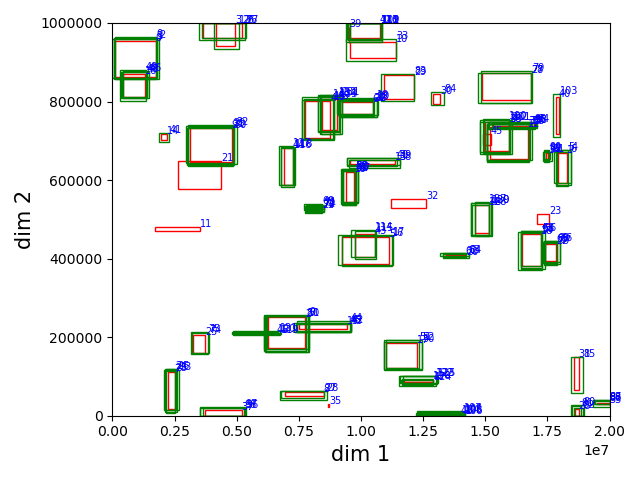

In [93]:
# training_set, testing_set = helper.generate_queryset_and_save(100, queryset_type=1) # 1-1
training_set, testing_set = helper.generate_queryset_and_save(100, queryset_type=2) # 1-X (X is 5 at most by default)
# training_set, testing_set = helper.generate_queryset_and_save(100, queryset_type=4) # mixture Gaussian
extended_training_set = helper.extend_queryset(training_set)
helper.visualize_queryset_and_dataset([0,1], training_set, testing_set)

<IPython.core.display.Javascript object>


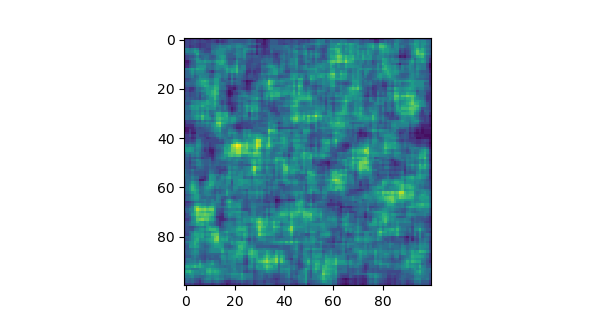

In [151]:
# query distribution analysis
hist = np.zeros((100,100))

for i in range(100):
    training_set, testing_set = helper.generate_queryset_and_save(100, queryset_type=2) # 1-X (X is 5 at most by default)
    for query in training_set:
        indexes = ()
        for k in range(len(used_dims)):
            query_index_L = int((query[k] - boundary[k]) / (boundary[len(used_dims) + k] - boundary[k])  * 100)
            query_index_U = int((query[len(used_dims) + k] - boundary[k]) / (boundary[len(used_dims) + k] - boundary[k]) * 100)
            #print(query_index_L, query_index_U)
            indexes += (slice(query_index_L, query_index_U, 1),)
        #print(indexes)
        hist[indexes] += 1
        
# heat map
fig = plt.figure(figsize=(6, 3.2))
plt.imshow(hist, interpolation='none')
plt.show()

In [45]:
# save the special queryset
# np.savetxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob1/uniform_queries_train.csv", training_set, delimiter=',')
# np.savetxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob1/uniform_queries_test.csv", testing_set, delimiter=',')
# np.savetxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob1/skewed_queries_train.csv", training_set, delimiter=',')
# np.savetxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob1/skewed_queries_test.csv", testing_set, delimiter=',')

In [46]:
# LB-Cost
results = helper.real_result_size(dataset, training_set)
# results = helper.real_result_size(dataset, testing_set)
max(sum(results)/len(results), block_size)

15066.78

### Create k-d tree.

In [546]:
# = = = = = Test PartitionAlgorithm (KDT) = = = = = 
pa1 = PartitionAlgorithm()
pa1.InitializeWithKDT(len(boundary)//2, boundary, dataset, data_threshold = block_size) # 447

### Test the logical IO of k-d tree on both training set and testing set (with visualization)

<IPython.core.display.Javascript object>


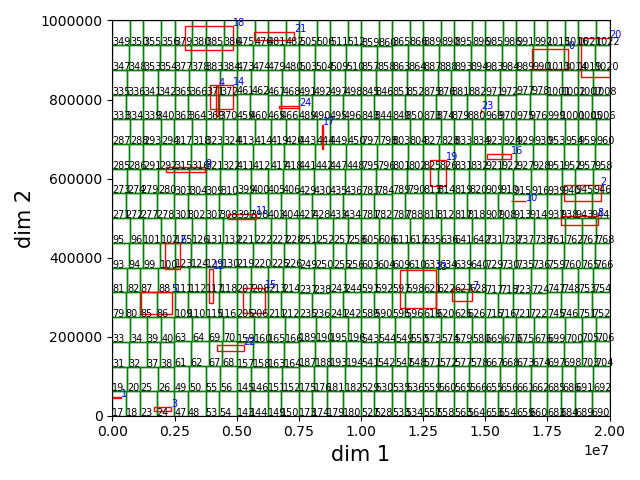

Total logical IOs: 1183847
Average logical IOs: 47353
query 0 [989, 990, 1013, 1014] cost: 46886
query 1 [17] cost: 11720
query 2 [938, 940, 943, 944, 945, 946] cost: 70328
query 3 [23, 24] cost: 23441
query 4 [369, 371] cost: 23442
query 5 [85, 86, 87, 88] cost: 46885
query 6 [88, 100, 102, 111, 123, 125] cost: 70330
query 7 [620, 622, 625, 626, 627, 628] cost: 70329
query 8 [761, 762, 767, 768, 938, 943, 944] cost: 82049
query 9 [280, 292, 303, 304, 315, 316] cost: 70328
query 10 [908, 913] cost: 23442
query 11 [132, 221, 222, 308, 397, 398] cost: 70327
query 12 [115, 117] cost: 23442
query 13 [595, 596, 597, 598, 619, 621] cost: 70327
query 14 [369, 370, 371, 372] cost: 46885
query 15 [205, 206, 207, 208] cost: 46883
query 16 [921, 922] cost: 23442
query 17 [442, 444] cost: 23443
query 18 [377, 378, 379, 380, 383, 384, 385, 386] cost: 93771
query 19 [813, 814, 825, 826] cost: 46885
query 20 [1007, 1008, 1019, 1020, 1021, 1022] cost: 70329
query 21 [475, 476, 481, 482] cost: 46887
qu

<IPython.core.display.Javascript object>


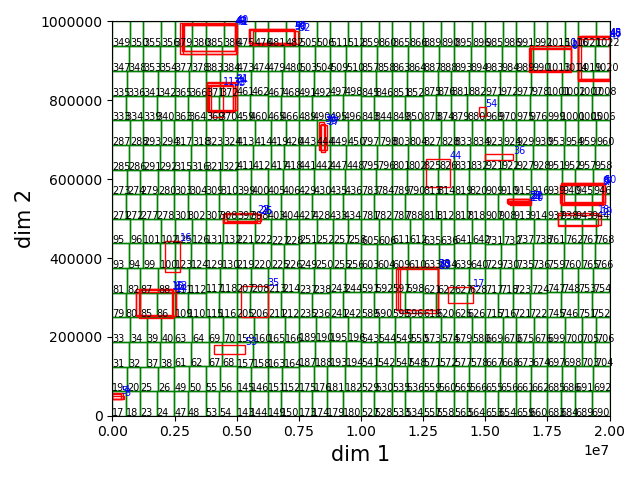

Total logical IOs: 3528123
Average logical IOs: 64147
query 0 [989, 990, 1013, 1014] cost: 46886
query 1 [977, 978, 989, 990, 991, 992, 1001, 1002, 1013, 1014, 1015, 1016] cost: 140658
query 2 [977, 978, 989, 990, 1001, 1002, 1013, 1014] cost: 93772
query 3 [17] cost: 11720
query 4 [17] cost: 11720
query 5 [17] cost: 11720
query 6 [938, 939, 940, 943, 944, 945, 946] cost: 82049
query 7 [938, 940, 943, 944, 945, 946] cost: 70328
query 8 [938, 940, 943, 944, 945, 946] cost: 70328
query 9 [937, 938, 939, 940, 943, 944, 945, 946] cost: 93770
query 10 [938, 939, 940, 943, 944, 945, 946] cost: 82049
query 11 [369, 370, 371, 372] cost: 46885
query 12 [34, 39, 40, 80, 82, 85, 86, 87, 88] cost: 105494
query 13 [80, 82, 85, 86, 87, 88, 109, 111] cost: 93770
query 14 [80, 82, 85, 86, 87, 88, 109, 111] cost: 93770
query 15 [80, 82, 85, 86, 87, 88] cost: 70328
query 16 [88, 100, 102, 111, 123, 125] cost: 70330
query 17 [620, 622, 625, 626, 627, 628] cost: 70329
query 18 [761, 762, 767, 768, 937, 93

64147

In [547]:
# pa1.partition_tree.visualize(queries = training_set, path="C:/Users/Cloud/iCloudDrive/NORA_experiments/plots/experiment_explanation/kdtree_train.png")
# pa1.partition_tree.visualize(queries = testing_set, path="C:/Users/Cloud/iCloudDrive/NORA_experiments/plots/experiment_explanation/kdtree_test.png")
pa1.partition_tree.visualize(queries = training_set)
pa1.partition_tree.evaluate_query_cost(training_set, True)
pa1.partition_tree.visualize(queries = testing_set)
pa1.partition_tree.evaluate_query_cost(testing_set, True)

### Test the logical IO of QdTree on both training set and testing set (with visualization)

In [548]:
# = = = = = Test PartitionAlgorithm (QDT) = = = = = 
pa2 = PartitionAlgorithm()
pa2.InitializeWithQDT(training_set, len(boundary)//2, boundary, dataset, data_threshold = block_size)

<IPython.core.display.Javascript object>


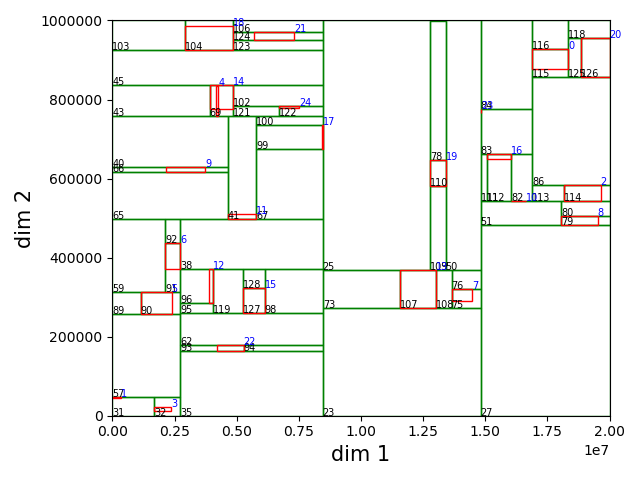

Total logical IOs: 744956
Average logical IOs: 29798
query 0 [115] cost: 28984
query 1 [31] cost: 25206
query 2 [114] cost: 21311
query 3 [32] cost: 14309
query 4 [69] cost: 23815
query 5 [90] cost: 25315
query 6 [91] cost: 22891
query 7 [75] cost: 17427
query 8 [79] cost: 12588
query 9 [66] cost: 17037
query 10 [82] cost: 34973
query 11 [41] cost: 87282
query 12 [96] cost: 33622
query 13 [107] cost: 41244
query 14 [69] cost: 23815
query 15 [127] cost: 18338
query 16 [112] cost: 33849
query 17 [99] cost: 50262
query 18 [104] cost: 44065
query 19 [110] cost: 14885
query 20 [126] cost: 36261
query 21 [124] cost: 23897
query 22 [93] cost: 11315
query 23 [83] cost: 69059
query 24 [122] cost: 13206


<IPython.core.display.Javascript object>


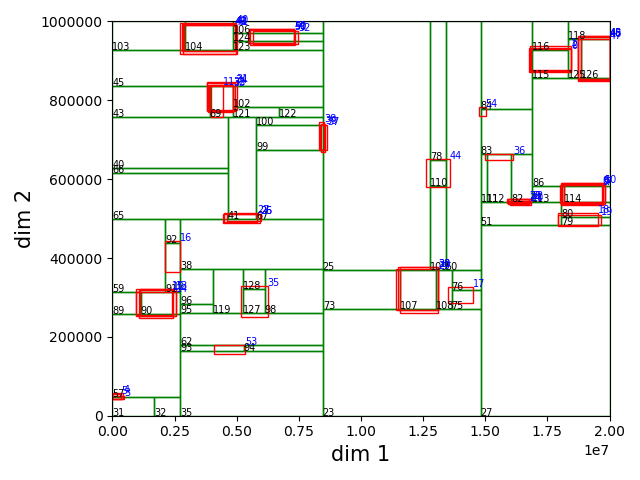

Total logical IOs: 24555857
Average logical IOs: 446470
query 0 [84, 115, 116, 125] cost: 215867
query 1 [84, 115, 116, 125] cost: 215867
query 2 [84, 115, 116, 125] cost: 215867
query 3 [31, 57] cost: 195822
query 4 [31, 57] cost: 195822
query 5 [31, 57] cost: 195822
query 6 [51, 80, 113, 114, 86] cost: 366408
query 7 [80, 113, 114, 86] cost: 309897
query 8 [80, 113, 114, 86] cost: 309897
query 9 [51, 80, 113, 114, 86] cost: 366408
query 10 [80, 113, 114, 86] cost: 309897
query 11 [40, 69, 45] cost: 427732
query 12 [57, 89, 90, 59, 91] cost: 355795
query 13 [57, 89, 90, 59, 91] cost: 355795
query 14 [57, 89, 90, 59, 91] cost: 355795
query 15 [57, 89, 90, 59, 91] cost: 355795
query 16 [59, 91, 92, 96, 38] cost: 403533
query 17 [108, 75, 76] cost: 54194
query 18 [27, 51, 79, 80] cost: 841880
query 19 [27, 51, 79, 80] cost: 841880
query 20 [51, 112, 82] cost: 125333
query 21 [51, 112, 82] cost: 125333
query 22 [51, 112, 82] cost: 125333
query 23 [51, 112, 82] cost: 125333
query 24 [51, 1

446470

In [549]:
# pa2.partition_tree.visualize(queries = training_set, path="C:/Users/Cloud/iCloudDrive/NORA_experiments/plots/experiment_explanation/qdtree_train.png")
pa2.partition_tree.visualize(queries = training_set)
pa2.partition_tree.evaluate_query_cost(training_set, True) # Average logical IOs: 196487
# pa2.partition_tree.visualize(queries = testing_set, path="C:/Users/Cloud/iCloudDrive/NORA_experiments/plots/experiment_explanation/qdtree_test.png")
pa2.partition_tree.visualize(queries = testing_set)
pa2.partition_tree.evaluate_query_cost(testing_set, True) # Average logical IOs: 196487

### Qd-tree trained by extended queries

In [ ]:
# # QdTree trained with extended queries
# pa2_2 = PartitionAlgorithm()
# pa2_2.InitializeWithQDT(extended_training_set, len(boundary)//2, boundary, dataset, data_threshold = block_size)

# pa2_2.partition_tree.visualize(queries = training_set)
# pa2_2.partition_tree.evaluate_query_cost(training_set, True) # Average logical IOs: 196487
# pa2_2.partition_tree.visualize(queries = testing_set)
# pa2_2.partition_tree.evaluate_query_cost(testing_set, True) # Average logical IOs: 196487

### Test the logical IO of NORA on both training set and testing set (with visualization)

In [291]:
# = = = = = Test PartitionAlgorithm (NORA) = = = = = 
pa3 = PartitionAlgorithm()
pa3.InitializeWithNORA(extended_training_set, len(boundary)//2, boundary, dataset, data_threshold = block_size)

Build Time (s): 16.2170832157135


<IPython.core.display.Javascript object>


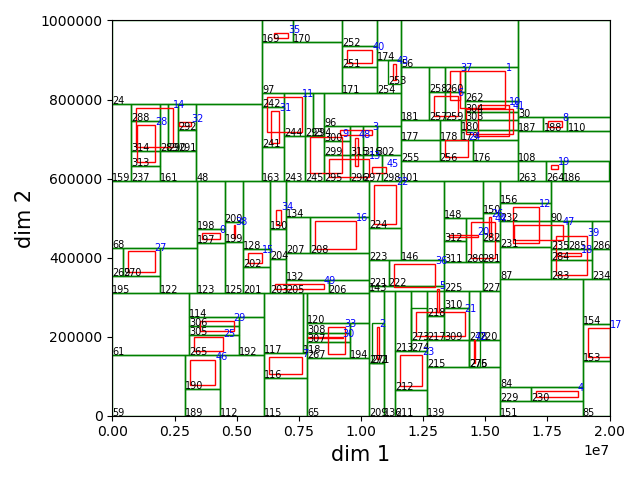

Total logical IOs: 35162
Average logical IOs: 703
query 0 [197] cost: 13821
query 1 [259, 260, 304, 262] cost: 103340
query 2 [271] cost: 13822
query 3 [300, 315, 316] cost: 33912
query 4 [230] cost: 21563
query 5 [218, 143] cost: 26861
query 6 [257, 259] cost: 32488
query 7 [116] cost: 32240
query 8 [188] cost: 10299
query 9 [245, 293, 294, 295, 299, 300] cost: 92160
query 10 [179, 180, 303, 304] cost: 66735
query 11 [241, 242, 244, 293] cost: 74953
query 12 [231, 232] cost: 67108
query 13 [295, 296, 297] cost: 45705
query 14 [314, 288, 289, 290] cost: 65943
query 15 [202] cost: 13361
query 16 [208] cost: 64687
query 17 [153] cost: 32280
query 18 [284] cost: 15431
query 19 [264] cost: 10382
query 20 [312, 280] cost: 33860
query 21 [273, 217, 218, 309, 278] cost: 79924
query 22 [224] cost: 46043
query 23 [212] cost: 38511
query 24 [256, 178, 179] cost: 54825
query 25 [265, 305] cost: 44224
query 26 [282] cost: 15637
query 27 [270] cost: 31728
query 28 [313, 314] cost: 36472
query 29 [3

<IPython.core.display.Javascript object>


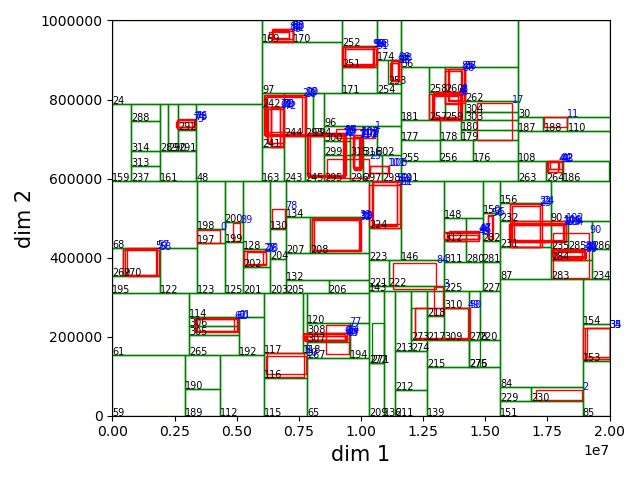

Total logical IOs: 21499
Average logical IOs: 191
query 0 [197] cost: 13821
query 1 [300, 315, 316] cost: 33912
query 2 [230] cost: 21563
query 3 [218, 143] cost: 26861
query 4 [257, 259] cost: 32488
query 5 [257, 259] cost: 32488
query 6 [257, 259] cost: 32488
query 7 [257, 259] cost: 32488
query 8 [257, 259] cost: 32488
query 9 [116] cost: 32240
query 10 [116] cost: 32240
query 11 [188] cost: 10299
query 12 [245, 295, 299, 300] cost: 67961
query 13 [245, 293, 294, 295, 299, 300] cost: 92160
query 14 [245, 293, 294, 295, 299, 300] cost: 92160
query 15 [245, 293, 294, 295, 299, 300] cost: 92160
query 16 [245, 293, 294, 295, 299, 300] cost: 92160
query 17 [179, 180, 303, 304] cost: 66735
query 18 [241, 242, 244] cost: 62854
query 19 [241, 242, 244, 293] cost: 74953
query 20 [241, 242, 244, 293] cost: 74953
query 21 [241, 242, 244] cost: 62854
query 22 [231, 232] cost: 67108
query 23 [231, 232] cost: 67108
query 24 [231, 232] cost: 67108
query 25 [295, 296, 297] cost: 45705
query 26 [202

34903

In [292]:
# pa3.partition_tree.visualize(queries = training_set, path="C:/Users/Cloud/iCloudDrive/NORA_experiments/plots/experiment_explanation/nora_train.png")
# pa3.partition_tree.visualize(queries = extended_training_set, path="C:/Users/Cloud/iCloudDrive/NORA_experiments/plots/experiment_explanation/nora_train.png")
pa3.partition_tree.visualize(queries = training_set)
pa3.partition_tree.evaluate_query_cost(extended_training_set, True)
# pa3.partition_tree.visualize(queries = testing_set, path="C:/Users/Cloud/iCloudDrive/NORA_experiments/plots/experiment_explanation/nora_test.png")
pa3.partition_tree.visualize(queries = testing_set)
pa3.partition_tree.evaluate_query_cost(testing_set, True)

In [101]:
# # = = = = Test Nora 1 BY 1 = = = =
# pa4 = PartitionAlgorithm()
# pa4.InitializeWithNORA(extended_training_set, len(boundary)//2, boundary, dataset, data_threshold = block_size, using_1_by_1 = True)
# pa4.partition_tree.visualize(queries = extended_training_set)
# pa4.partition_tree.evaluate_query_cost(extended_training_set)
# pa4.partition_tree.visualize(queries = testing_set)
# pa4.partition_tree.evaluate_query_cost(testing_set)

### NORA without extended queries

In [16]:
# = = = = = NORA without extended queries = = = = = 
pa3_2 = PartitionAlgorithm()
pa3_2.InitializeWithNORA(training_set, len(boundary)//2, boundary, dataset, data_threshold = block_size)

Build Time (s): 15.613705158233643


<IPython.core.display.Javascript object>


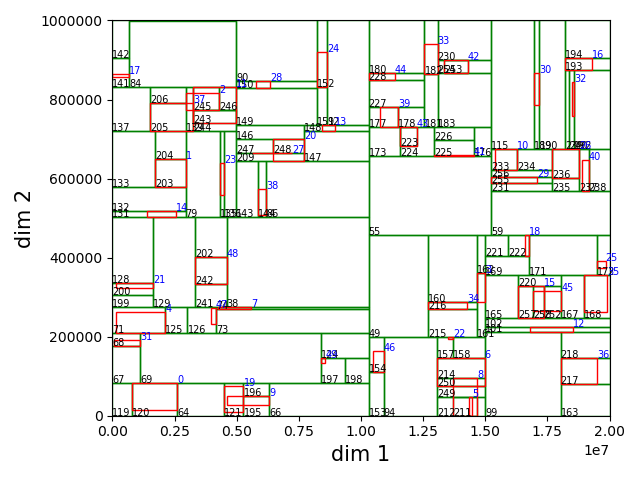

Total logical IOs: 1089591
Average logical IOs: 21791
query 0 [120] cost: 46417
query 1 [203] cost: 27097
query 2 [139, 245] cost: 30474
query 3 [161] cost: 15441
query 4 [71] cost: 41623
query 5 [211] cost: 14607
query 6 [250, 214] cost: 41336
query 7 [74] cost: 11993
query 8 [211, 249, 250] cost: 42083
query 9 [121, 195] cost: 37801
query 10 [233] cost: 15943
query 11 [139, 243, 245, 246] cost: 57146
query 12 [101] cost: 21766
query 13 [148] cost: 13323
query 14 [131] cost: 12652
query 15 [257, 258] cost: 25765
query 16 [193] cost: 15852
query 17 [141] cost: 16703
query 18 [222] cost: 13969
query 19 [121] cost: 20800
query 20 [209, 248] cost: 30849
query 21 [200] cost: 16098
query 22 [157] cost: 11878
query 23 [135] cost: 11164
query 24 [152] cost: 18902
query 25 [172] cost: 15498
query 26 [236] cost: 22118
query 27 [209] cost: 18136
query 28 [150] cost: 17007
query 29 [255] cost: 12440
query 30 [189] cost: 22669
query 31 [68] cost: 10020
query 32 [240] cost: 11898
query 33 [182] cos

<IPython.core.display.Javascript object>


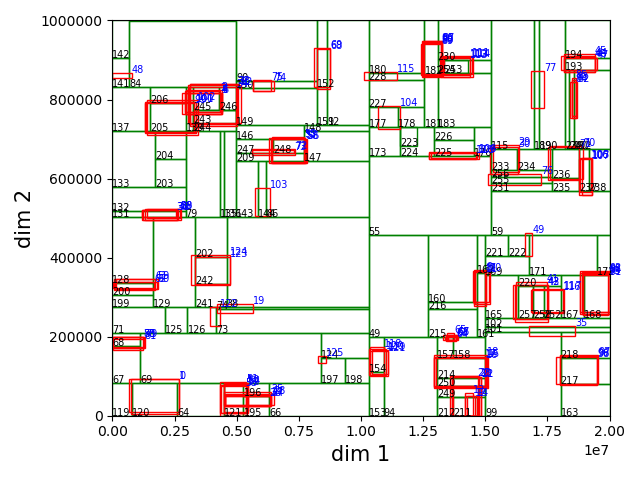

Total logical IOs: 29262194
Average logical IOs: 232239
query 0 [119, 120, 64, 67, 69] cost: 418331
query 1 [119, 120, 64, 67, 69] cost: 418331
query 2 [205, 206, 139, 243, 245, 246] cost: 104268
query 3 [205, 206, 139, 243, 245, 246] cost: 104268
query 4 [205, 206, 139, 243, 245, 246] cost: 104268
query 5 [205, 206, 139, 243, 245, 246] cost: 104268
query 6 [205, 206, 139, 243, 245, 246] cost: 104268
query 7 [216, 160, 161, 162, 165, 169] cost: 210270
query 8 [160, 161, 162, 165, 169] cost: 199224
query 9 [216, 160, 161, 162, 165, 169] cost: 210270
query 10 [216, 160, 161, 162, 165, 169] cost: 210270
query 11 [216, 160, 161, 162, 165, 169] cost: 210270
query 12 [211, 249] cost: 31256
query 13 [211, 249] cost: 31256
query 14 [211, 249] cost: 31256
query 15 [94, 249, 250, 214, 157, 158, 99] cost: 408986
query 16 [94, 249, 250, 214, 157, 158, 99] cost: 408986
query 17 [94, 249, 250, 214, 157, 158] cost: 216172
query 18 [94, 249, 250, 214, 157, 158, 99] cost: 408986
query 19 [73, 74, 241, 

232239

In [17]:
pa3_2.partition_tree.visualize(queries = training_set)
pa3_2.partition_tree.evaluate_query_cost(training_set, True)
pa3_2.partition_tree.visualize(queries = testing_set)
pa3_2.partition_tree.evaluate_query_cost(testing_set, True)

In [18]:
# = = = = = NORA without extended queries (bounding split in inner node) = = = = = 
pa3_3 = PartitionAlgorithm()
pa3_3.InitializeWithNORA(training_set, len(boundary)//2, boundary, dataset, data_threshold = block_size, using_1_by_1 = True)
# pa3_3.partition_tree.nid_node_dict[22].__dict__ # show all the attributes

Build Time (s): 79.73106741905212


<IPython.core.display.Javascript object>


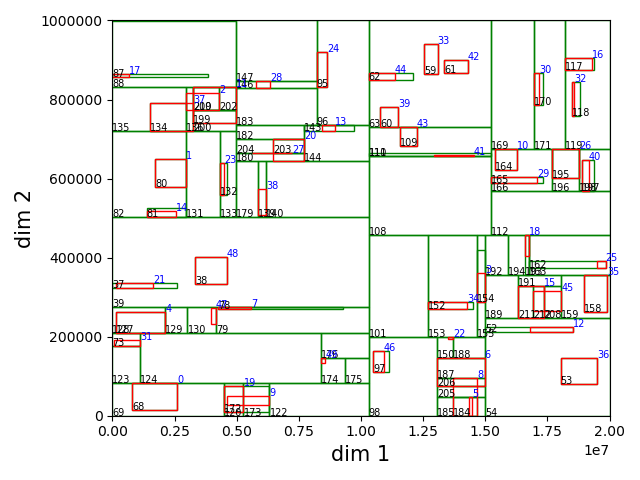

Total logical IOs: 994761
Average logical IOs: 19895
query 0 [68] cost: 39433
query 1 [80] cost: 27097
query 2 [136, 209] cost: 41082
query 3 [154] cost: 9999
query 4 [127] cost: 32423
query 5 [184] cost: 14607
query 6 [206, 187] cost: 41336
query 7 [78] cost: 10000
query 8 [184, 205, 206] cost: 42083
query 9 [120, 172] cost: 60853
query 10 [164] cost: 15680
query 11 [136, 199, 209, 202] cost: 67754
query 12 [52] cost: 15325
query 13 [143] cost: 10000
query 14 [81] cost: 10000
query 15 [211, 212] cost: 25765
query 16 [117] cost: 10000
query 17 [87] cost: 10000
query 18 [193] cost: 7729
query 19 [120] cost: 20800
query 20 [180, 203] cost: 30849
query 21 [37] cost: 10000
query 22 [150] cost: 11878
query 23 [132] cost: 10000
query 24 [95] cost: 10446
query 25 [162] cost: 17865
query 26 [195] cost: 21768
query 27 [180] cost: 18136
query 28 [146] cost: 17007
query 29 [165] cost: 10000
query 30 [170] cost: 10000
query 31 [73] cost: 10020
query 32 [118] cost: 10000
query 33 [59] cost: 11108
q

<IPython.core.display.Javascript object>


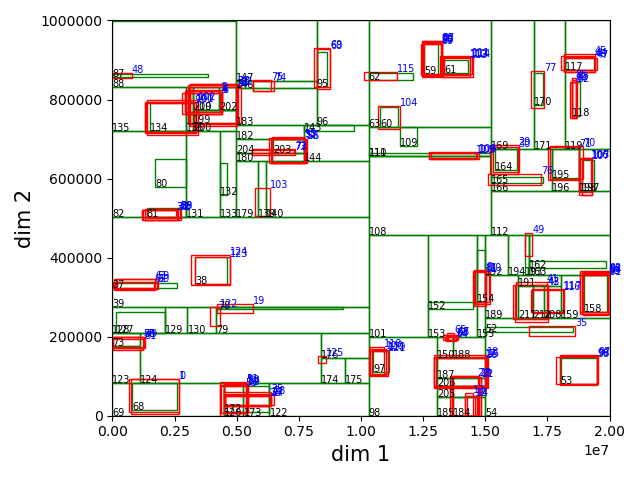

Total logical IOs: 18636605
Average logical IOs: 147909
query 0 [68, 69] cost: 112961
query 1 [68, 69] cost: 112961
query 2 [134, 135, 136, 199, 209, 202] cost: 166249
query 3 [134, 135, 136, 199, 209, 202] cost: 166249
query 4 [134, 135, 136, 199, 209, 202] cost: 166249
query 5 [134, 135, 136, 199, 209, 202] cost: 166249
query 6 [134, 135, 136, 199, 209, 202] cost: 166249
query 7 [154, 155] cost: 25721
query 8 [154, 155] cost: 25721
query 9 [154, 155] cost: 25721
query 10 [154, 155] cost: 25721
query 11 [154, 155] cost: 25721
query 12 [184, 205] cost: 31256
query 13 [184, 205] cost: 31256
query 14 [184, 205] cost: 31256
query 15 [205, 206, 187, 150] cost: 69863
query 16 [205, 206, 187, 150] cost: 69863
query 17 [205, 206, 187, 150] cost: 69863
query 18 [205, 206, 187, 150] cost: 69863
query 19 [78, 79] cost: 124601
query 20 [184, 185, 205, 206, 187] cost: 83222
query 21 [184, 185, 205, 206, 187] cost: 83222
query 22 [184, 185, 205, 206, 187] cost: 83222
query 23 [184, 185, 205, 206, 1

147909

In [19]:
pa3_3.partition_tree.visualize(queries = training_set)
pa3_3.partition_tree.evaluate_query_cost(training_set, True)
pa3_3.partition_tree.visualize(queries = testing_set)
pa3_3.partition_tree.evaluate_query_cost(testing_set, True)

# Test Beam Search

In [33]:
pa_beam_nora = PartitionAlgorithm()
pa_beam_nora.InitializeWithNORA(training_set, len(boundary)//2, boundary, dataset, data_threshold = block_size, using_1_by_1 = True, 
                                using_kd = False, depth_limit = None, return_query_cost = False, using_beam_search = True, 
                                candidate_size = 10, candidate_depth = 3)
pa_beam_nora.partition_tree.evaluate_query_cost(training_set)

Build Time (s): 396.50184655189514


21472

# Test Rtree Filter

In [14]:
for capacity_ratio in [0.5, 0.2, 0.1, 0.05, 0.02, 0.01]:
    
    print("= = = = = Current Capacity Ratio:", capacity_ratio, "(", int(block_size*capacity_ratio),") = = = = =")

    print("= = = NORA = = =")
    pa_rf_nora = PartitionAlgorithm() # we don't need to optimize it?
    pa_rf_nora.InitializeWithNORA(training_set, len(boundary)//2, boundary, dataset, data_threshold = block_size, using_1_by_1 = False)
    pa_rf_nora.CreateRtreeFilter(block_size, capacity_ratio)
    pa_rf_nora.partition_tree.evaluate_query_cost(training_set, print_result = True, using_rtree_filter = False)
    print("")
    pa_rf_nora.partition_tree.evaluate_query_cost(training_set, print_result = True, using_rtree_filter = True)
    print("")

    print("= = = kd-Tree = = =")
    pa_rf_kd = PartitionAlgorithm() # we don't need to optimize it?
    pa_rf_kd.InitializeWithKDT(len(boundary)//2, boundary, dataset, data_threshold = block_size)
    pa_rf_kd.CreateRtreeFilter(block_size, capacity_ratio)
    pa_rf_kd.partition_tree.evaluate_query_cost(training_set, print_result = True, using_rtree_filter = False)
    print("")
    pa_rf_kd.partition_tree.evaluate_query_cost(training_set, print_result = True, using_rtree_filter = True)
    print("")

    print("= = = Qd-Tree = = =")
    pa_rf_qd = PartitionAlgorithm() # we don't need to optimize it?
    pa_rf_qd.InitializeWithQDT(training_set, len(boundary)//2, boundary, dataset, data_threshold = block_size)
    pa_rf_qd.CreateRtreeFilter(block_size, capacity_ratio)
    pa_rf_qd.partition_tree.evaluate_query_cost(training_set, print_result = True, using_rtree_filter = False)
    print("")
    pa_rf_qd.partition_tree.evaluate_query_cost(training_set, print_result = True, using_rtree_filter = True)
    print("")

= = = = = Current Capacity Ratio: 0.5 ( 5000 ) = = = = =
= = = NORA = = =
Build Time (s): 15.475178241729736
Total logical IOs: 1089591
Average logical IOs: 21791
query 0 [120] cost: 46417
query 1 [203] cost: 27097
query 2 [139, 245] cost: 30474
query 3 [161] cost: 15441
query 4 [71] cost: 41623
query 5 [211] cost: 14607
query 6 [250, 214] cost: 41336
query 7 [74] cost: 11993
query 8 [211, 249, 250] cost: 42083
query 9 [121, 195] cost: 37801
query 10 [233] cost: 15943
query 11 [139, 243, 245, 246] cost: 57146
query 12 [101] cost: 21766
query 13 [148] cost: 13323
query 14 [131] cost: 12652
query 15 [257, 258] cost: 25765
query 16 [193] cost: 15852
query 17 [141] cost: 16703
query 18 [222] cost: 13969
query 19 [121] cost: 20800
query 20 [209, 248] cost: 30849
query 21 [200] cost: 16098
query 22 [157] cost: 11878
query 23 [135] cost: 11164
query 24 [152] cost: 18902
query 25 [172] cost: 15498
query 26 [236] cost: 22118
query 27 [209] cost: 18136
query 28 [150] cost: 17007
query 29 [255] c

Build Time (s): 15.721000671386719
Total logical IOs: 1089591
Average logical IOs: 21791
query 0 [120] cost: 46417
query 1 [203] cost: 27097
query 2 [139, 245] cost: 30474
query 3 [161] cost: 15441
query 4 [71] cost: 41623
query 5 [211] cost: 14607
query 6 [250, 214] cost: 41336
query 7 [74] cost: 11993
query 8 [211, 249, 250] cost: 42083
query 9 [121, 195] cost: 37801
query 10 [233] cost: 15943
query 11 [139, 243, 245, 246] cost: 57146
query 12 [101] cost: 21766
query 13 [148] cost: 13323
query 14 [131] cost: 12652
query 15 [257, 258] cost: 25765
query 16 [193] cost: 15852
query 17 [141] cost: 16703
query 18 [222] cost: 13969
query 19 [121] cost: 20800
query 20 [209, 248] cost: 30849
query 21 [200] cost: 16098
query 22 [157] cost: 11878
query 23 [135] cost: 11164
query 24 [152] cost: 18902
query 25 [172] cost: 15498
query 26 [236] cost: 22118
query 27 [209] cost: 18136
query 28 [150] cost: 17007
query 29 [255] cost: 12440
query 30 [189] cost: 22669
query 31 [68] cost: 10020
query 32 [

Build Time (s): 15.333976984024048
Total logical IOs: 1089591
Average logical IOs: 21791
query 0 [120] cost: 46417
query 1 [203] cost: 27097
query 2 [139, 245] cost: 30474
query 3 [161] cost: 15441
query 4 [71] cost: 41623
query 5 [211] cost: 14607
query 6 [250, 214] cost: 41336
query 7 [74] cost: 11993
query 8 [211, 249, 250] cost: 42083
query 9 [121, 195] cost: 37801
query 10 [233] cost: 15943
query 11 [139, 243, 245, 246] cost: 57146
query 12 [101] cost: 21766
query 13 [148] cost: 13323
query 14 [131] cost: 12652
query 15 [257, 258] cost: 25765
query 16 [193] cost: 15852
query 17 [141] cost: 16703
query 18 [222] cost: 13969
query 19 [121] cost: 20800
query 20 [209, 248] cost: 30849
query 21 [200] cost: 16098
query 22 [157] cost: 11878
query 23 [135] cost: 11164
query 24 [152] cost: 18902
query 25 [172] cost: 15498
query 26 [236] cost: 22118
query 27 [209] cost: 18136
query 28 [150] cost: 17007
query 29 [255] cost: 12440
query 30 [189] cost: 22669
query 31 [68] cost: 10020
query 32 [

Build Time (s): 15.352037191390991
Total logical IOs: 1089591
Average logical IOs: 21791
query 0 [120] cost: 46417
query 1 [203] cost: 27097
query 2 [139, 245] cost: 30474
query 3 [161] cost: 15441
query 4 [71] cost: 41623
query 5 [211] cost: 14607
query 6 [250, 214] cost: 41336
query 7 [74] cost: 11993
query 8 [211, 249, 250] cost: 42083
query 9 [121, 195] cost: 37801
query 10 [233] cost: 15943
query 11 [139, 243, 245, 246] cost: 57146
query 12 [101] cost: 21766
query 13 [148] cost: 13323
query 14 [131] cost: 12652
query 15 [257, 258] cost: 25765
query 16 [193] cost: 15852
query 17 [141] cost: 16703
query 18 [222] cost: 13969
query 19 [121] cost: 20800
query 20 [209, 248] cost: 30849
query 21 [200] cost: 16098
query 22 [157] cost: 11878
query 23 [135] cost: 11164
query 24 [152] cost: 18902
query 25 [172] cost: 15498
query 26 [236] cost: 22118
query 27 [209] cost: 18136
query 28 [150] cost: 17007
query 29 [255] cost: 12440
query 30 [189] cost: 22669
query 31 [68] cost: 10020
query 32 [

Build Time (s): 15.299104690551758
Total logical IOs: 1089591
Average logical IOs: 21791
query 0 [120] cost: 46417
query 1 [203] cost: 27097
query 2 [139, 245] cost: 30474
query 3 [161] cost: 15441
query 4 [71] cost: 41623
query 5 [211] cost: 14607
query 6 [250, 214] cost: 41336
query 7 [74] cost: 11993
query 8 [211, 249, 250] cost: 42083
query 9 [121, 195] cost: 37801
query 10 [233] cost: 15943
query 11 [139, 243, 245, 246] cost: 57146
query 12 [101] cost: 21766
query 13 [148] cost: 13323
query 14 [131] cost: 12652
query 15 [257, 258] cost: 25765
query 16 [193] cost: 15852
query 17 [141] cost: 16703
query 18 [222] cost: 13969
query 19 [121] cost: 20800
query 20 [209, 248] cost: 30849
query 21 [200] cost: 16098
query 22 [157] cost: 11878
query 23 [135] cost: 11164
query 24 [152] cost: 18902
query 25 [172] cost: 15498
query 26 [236] cost: 22118
query 27 [209] cost: 18136
query 28 [150] cost: 17007
query 29 [255] cost: 12440
query 30 [189] cost: 22669
query 31 [68] cost: 10020
query 32 [

Build Time (s): 15.887999534606934
Total logical IOs: 1089591
Average logical IOs: 21791
query 0 [120] cost: 46417
query 1 [203] cost: 27097
query 2 [139, 245] cost: 30474
query 3 [161] cost: 15441
query 4 [71] cost: 41623
query 5 [211] cost: 14607
query 6 [250, 214] cost: 41336
query 7 [74] cost: 11993
query 8 [211, 249, 250] cost: 42083
query 9 [121, 195] cost: 37801
query 10 [233] cost: 15943
query 11 [139, 243, 245, 246] cost: 57146
query 12 [101] cost: 21766
query 13 [148] cost: 13323
query 14 [131] cost: 12652
query 15 [257, 258] cost: 25765
query 16 [193] cost: 15852
query 17 [141] cost: 16703
query 18 [222] cost: 13969
query 19 [121] cost: 20800
query 20 [209, 248] cost: 30849
query 21 [200] cost: 16098
query 22 [157] cost: 11878
query 23 [135] cost: 11164
query 24 [152] cost: 18902
query 25 [172] cost: 15498
query 26 [236] cost: 22118
query 27 [209] cost: 18136
query 28 [150] cost: 17007
query 29 [255] cost: 12440
query 30 [189] cost: 22669
query 31 [68] cost: 10020
query 32 [

In [47]:
# Using Tweet Dataset
TWEET = np.genfromtxt('C:/Users/Cloud/Desktop/LearnIndex/data/SortedSingleDimPOIs2.csv', delimiter=',')
cols = [1, 0] # change the shape to: first lon, then lat
TWEET_dataset = TWEET[:,cols]

# generate a collection of queries:
Tweet_queries = helper._DatasetAndQuerysetHelper__generate_random_query(50, [1,1], [[-180,180],[-90,90]], [36,18])
TWEET_boundary = [-180, -90, 180, 90]
TWEET_block_size = 2000 # 1.1M compared to 6M

In [50]:
def total_MBR_volume(partition_tree, num_dims):
    leaves = partition_tree.get_leaves()
    MBRs = []
    for leaf in leaves:
        if leaf.rtree_filters is not None:
            MBRs += leaf.rtree_filters
    total_volume = 0
    for MBR in MBRs:
        volume = 1
        for k in range(num_dims):
            volume *= MBR[k + num_dims] - MBR[k]
        total_volume += volume
    print("!!! Total Volume:",total_volume)


for capacity_ratio in [0.5, 0.2, 0.1, 0.05, 0.02, 0.01]:
    
    print("= = = = = Current Capacity Ratio:", capacity_ratio, "(", int(TWEET_block_size*capacity_ratio),") = = = = =")
    
    print("= = = NORA = = =")
    pa_rf_nora = PartitionAlgorithm() # we don't need to optimize it?
    pa_rf_nora.InitializeWithNORA(Tweet_queries, 2, TWEET_boundary, TWEET_dataset, data_threshold = TWEET_block_size, using_1_by_1 = True, using_kd = True)
    pa_rf_nora.CreateRtreeFilter(TWEET_block_size, capacity_ratio)
    pa_rf_nora.partition_tree.evaluate_query_cost(Tweet_queries, print_result = True, using_rtree_filter = False)
    print("")
    pa_rf_nora.partition_tree.evaluate_query_cost(Tweet_queries, print_result = True, using_rtree_filter = True)
    print("")

    print("= = = kd-Tree = = =")
    pa_rf_kd = PartitionAlgorithm() # we don't need to optimize it?
    pa_rf_kd.InitializeWithKDT(2, TWEET_boundary, TWEET_dataset, data_threshold = TWEET_block_size)
    pa_rf_kd.CreateRtreeFilter(TWEET_block_size, capacity_ratio)
    pa_rf_kd.partition_tree.evaluate_query_cost(Tweet_queries, print_result = True, using_rtree_filter = False)
    print("")
    pa_rf_kd.partition_tree.evaluate_query_cost(Tweet_queries, print_result = True, using_rtree_filter = True)
    print("")

    print("= = = Qd-Tree = = =")
    pa_rf_qd = PartitionAlgorithm() # we don't need to optimize it?
    pa_rf_qd.InitializeWithQDT(Tweet_queries, 2, TWEET_boundary, TWEET_dataset, data_threshold = TWEET_block_size)
    pa_rf_qd.CreateRtreeFilter(TWEET_block_size, capacity_ratio)
    pa_rf_qd.partition_tree.evaluate_query_cost(Tweet_queries, print_result = True, using_rtree_filter = False)
    print("")
    pa_rf_qd.partition_tree.evaluate_query_cost(Tweet_queries, print_result = True, using_rtree_filter = True)
    print("")
    
    total_MBR_volume(pa_rf_nora.partition_tree, 2)
    print("")

= = = = = Current Capacity Ratio: 0.5 ( 1000 ) = = = = =
= = = NORA = = =
Build Time (s): 52.45396113395691
Total logical IOs: 129618
Average logical IOs: 2592
query 0 [40, 91] cost: 3319
query 1 [7] cost: 2711
query 2 [34] cost: 2108
query 3 [7] cost: 2711
query 4 [28] cost: 2210
query 5 [7] cost: 2711
query 6 [58] cost: 2974
query 7 [7] cost: 2711
query 8 [75] cost: 0
query 9 [30] cost: 3792
query 10 [86] cost: 0
query 11 [70] cost: 3548
query 12 [28] cost: 2210
query 13 [84] cost: 0
query 14 [71, 80] cost: 2915
query 15 [7] cost: 2711
query 16 [7] cost: 2711
query 17 [34] cost: 2108
query 18 [91] cost: 3314
query 19 [70, 28] cost: 5758
query 20 [71] cost: 2915
query 21 [28] cost: 2210
query 22 [55] cost: 0
query 23 [67, 28] cost: 2210
query 24 [50] cost: 0
query 25 [7, 15] cost: 6179
query 26 [7] cost: 2711
query 27 [71, 72, 73] cost: 5896
query 28 [7] cost: 2711
query 29 [82] cost: 0
query 30 [7] cost: 2711
query 31 [30] cost: 3792
query 32 [28] cost: 2210
query 33 [34] cost: 2108


Build Time (s): 51.1211678981781
Total logical IOs: 129618
Average logical IOs: 2592
query 0 [40, 91] cost: 3319
query 1 [7] cost: 2711
query 2 [34] cost: 2108
query 3 [7] cost: 2711
query 4 [28] cost: 2210
query 5 [7] cost: 2711
query 6 [58] cost: 2974
query 7 [7] cost: 2711
query 8 [75] cost: 0
query 9 [30] cost: 3792
query 10 [86] cost: 0
query 11 [70] cost: 3548
query 12 [28] cost: 2210
query 13 [84] cost: 0
query 14 [71, 80] cost: 2915
query 15 [7] cost: 2711
query 16 [7] cost: 2711
query 17 [34] cost: 2108
query 18 [91] cost: 3314
query 19 [70, 28] cost: 5758
query 20 [71] cost: 2915
query 21 [28] cost: 2210
query 22 [55] cost: 0
query 23 [67, 28] cost: 2210
query 24 [50] cost: 0
query 25 [7, 15] cost: 6179
query 26 [7] cost: 2711
query 27 [71, 72, 73] cost: 5896
query 28 [7] cost: 2711
query 29 [82] cost: 0
query 30 [7] cost: 2711
query 31 [30] cost: 3792
query 32 [28] cost: 2210
query 33 [34] cost: 2108
query 34 [91] cost: 3314
query 35 [7] cost: 2711
query 36 [7] cost: 2711
qu

Build Time (s): 51.166011333465576
Total logical IOs: 129618
Average logical IOs: 2592
query 0 [40, 91] cost: 3319
query 1 [7] cost: 2711
query 2 [34] cost: 2108
query 3 [7] cost: 2711
query 4 [28] cost: 2210
query 5 [7] cost: 2711
query 6 [58] cost: 2974
query 7 [7] cost: 2711
query 8 [75] cost: 0
query 9 [30] cost: 3792
query 10 [86] cost: 0
query 11 [70] cost: 3548
query 12 [28] cost: 2210
query 13 [84] cost: 0
query 14 [71, 80] cost: 2915
query 15 [7] cost: 2711
query 16 [7] cost: 2711
query 17 [34] cost: 2108
query 18 [91] cost: 3314
query 19 [70, 28] cost: 5758
query 20 [71] cost: 2915
query 21 [28] cost: 2210
query 22 [55] cost: 0
query 23 [67, 28] cost: 2210
query 24 [50] cost: 0
query 25 [7, 15] cost: 6179
query 26 [7] cost: 2711
query 27 [71, 72, 73] cost: 5896
query 28 [7] cost: 2711
query 29 [82] cost: 0
query 30 [7] cost: 2711
query 31 [30] cost: 3792
query 32 [28] cost: 2210
query 33 [34] cost: 2108
query 34 [91] cost: 3314
query 35 [7] cost: 2711
query 36 [7] cost: 2711


Build Time (s): 51.189000368118286
Total logical IOs: 129618
Average logical IOs: 2592
query 0 [40, 91] cost: 3319
query 1 [7] cost: 2711
query 2 [34] cost: 2108
query 3 [7] cost: 2711
query 4 [28] cost: 2210
query 5 [7] cost: 2711
query 6 [58] cost: 2974
query 7 [7] cost: 2711
query 8 [75] cost: 0
query 9 [30] cost: 3792
query 10 [86] cost: 0
query 11 [70] cost: 3548
query 12 [28] cost: 2210
query 13 [84] cost: 0
query 14 [71, 80] cost: 2915
query 15 [7] cost: 2711
query 16 [7] cost: 2711
query 17 [34] cost: 2108
query 18 [91] cost: 3314
query 19 [70, 28] cost: 5758
query 20 [71] cost: 2915
query 21 [28] cost: 2210
query 22 [55] cost: 0
query 23 [67, 28] cost: 2210
query 24 [50] cost: 0
query 25 [7, 15] cost: 6179
query 26 [7] cost: 2711
query 27 [71, 72, 73] cost: 5896
query 28 [7] cost: 2711
query 29 [82] cost: 0
query 30 [7] cost: 2711
query 31 [30] cost: 3792
query 32 [28] cost: 2210
query 33 [34] cost: 2108
query 34 [91] cost: 3314
query 35 [7] cost: 2711
query 36 [7] cost: 2711


Build Time (s): 51.30700087547302
Total logical IOs: 129618
Average logical IOs: 2592
query 0 [40, 91] cost: 3319
query 1 [7] cost: 2711
query 2 [34] cost: 2108
query 3 [7] cost: 2711
query 4 [28] cost: 2210
query 5 [7] cost: 2711
query 6 [58] cost: 2974
query 7 [7] cost: 2711
query 8 [75] cost: 0
query 9 [30] cost: 3792
query 10 [86] cost: 0
query 11 [70] cost: 3548
query 12 [28] cost: 2210
query 13 [84] cost: 0
query 14 [71, 80] cost: 2915
query 15 [7] cost: 2711
query 16 [7] cost: 2711
query 17 [34] cost: 2108
query 18 [91] cost: 3314
query 19 [70, 28] cost: 5758
query 20 [71] cost: 2915
query 21 [28] cost: 2210
query 22 [55] cost: 0
query 23 [67, 28] cost: 2210
query 24 [50] cost: 0
query 25 [7, 15] cost: 6179
query 26 [7] cost: 2711
query 27 [71, 72, 73] cost: 5896
query 28 [7] cost: 2711
query 29 [82] cost: 0
query 30 [7] cost: 2711
query 31 [30] cost: 3792
query 32 [28] cost: 2210
query 33 [34] cost: 2108
query 34 [91] cost: 3314
query 35 [7] cost: 2711
query 36 [7] cost: 2711
q

Build Time (s): 51.17596220970154
Total logical IOs: 129618
Average logical IOs: 2592
query 0 [40, 91] cost: 3319
query 1 [7] cost: 2711
query 2 [34] cost: 2108
query 3 [7] cost: 2711
query 4 [28] cost: 2210
query 5 [7] cost: 2711
query 6 [58] cost: 2974
query 7 [7] cost: 2711
query 8 [75] cost: 0
query 9 [30] cost: 3792
query 10 [86] cost: 0
query 11 [70] cost: 3548
query 12 [28] cost: 2210
query 13 [84] cost: 0
query 14 [71, 80] cost: 2915
query 15 [7] cost: 2711
query 16 [7] cost: 2711
query 17 [34] cost: 2108
query 18 [91] cost: 3314
query 19 [70, 28] cost: 5758
query 20 [71] cost: 2915
query 21 [28] cost: 2210
query 22 [55] cost: 0
query 23 [67, 28] cost: 2210
query 24 [50] cost: 0
query 25 [7, 15] cost: 6179
query 26 [7] cost: 2711
query 27 [71, 72, 73] cost: 5896
query 28 [7] cost: 2711
query 29 [82] cost: 0
query 30 [7] cost: 2711
query 31 [30] cost: 3792
query 32 [28] cost: 2210
query 33 [34] cost: 2108
query 34 [91] cost: 3314
query 35 [7] cost: 2711
query 36 [7] cost: 2711
q

In [719]:
leaves = pa_rf_nora.partition_tree.get_leaves()
MBRs = []
for leaf in leaves:
    if leaf.rtree_filters is not None:
        MBRs += leaf.rtree_filters

<IPython.core.display.Javascript object>


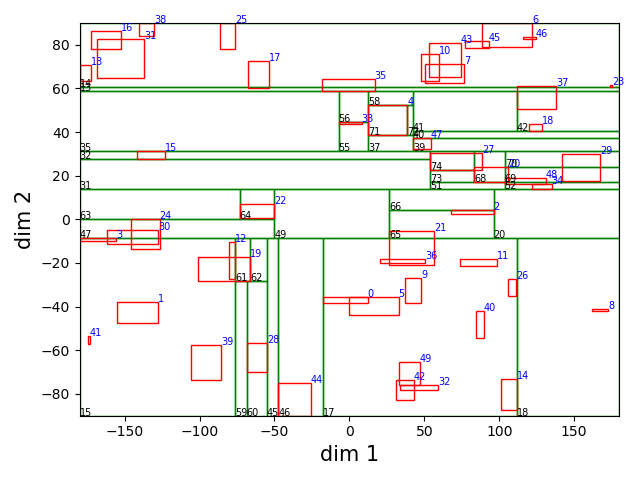

<IPython.core.display.Javascript object>


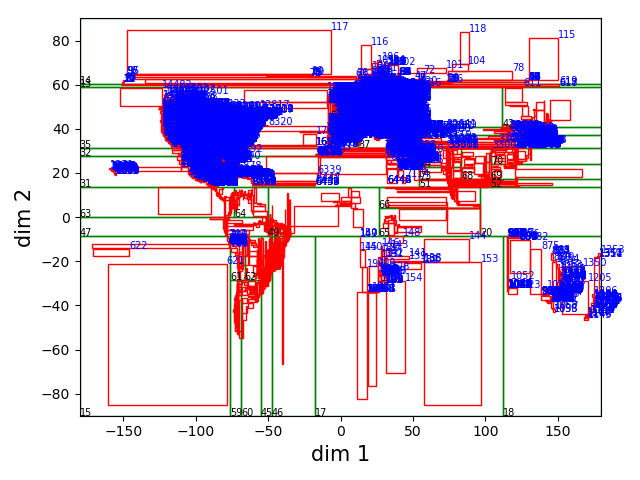

In [720]:
pa_rf_qd.partition_tree.visualize(queries = Tweet_queries)
pa_rf_qd.partition_tree.visualize(queries = MBRs)

# Test Redundant Partition

In [690]:
# First create a normal partition

pa_rp_kd = PartitionAlgorithm()
pa_rp_kd.InitializeWithKDT(len(boundary)//2, boundary, dataset, data_threshold = block_size) # 447

pa_rp_qd = PartitionAlgorithm()
pa_rp_qd.InitializeWithQDT(training_set, len(boundary)//2, boundary, dataset, data_threshold = block_size)

pa_rp_nora = PartitionAlgorithm() # we don't need to optimize it?
pa_rp_nora.InitializeWithNORA(training_set, len(boundary)//2, boundary, dataset, data_threshold = block_size, 
                              using_1_by_1 = True, using_kd = True)

results = helper.real_result_size(dataset, training_set)
# results = helper.real_result_size(dataset, testing_set)
print("LB-Cost:", max(sum(results)/len(results), block_size))

for redundant_ratio in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5]:
    print("= = = Result For Redundant Ratio", redundant_ratio, "= = =")
    print("!!!KDT:")
    pa_rp_kd.RedundantPartitions(int(redundant_ratio*len(dataset)), training_set, dataset, block_size)
    print("!!!QDT:")
    pa_rp_qd.RedundantPartitions(int(redundant_ratio*len(dataset)), training_set, dataset, block_size)
    print("!!!NORA:")
    pa_rp_nora.RedundantPartitions(int(redundant_ratio*len(dataset)), training_set, dataset, block_size)
    print("")

Build Time (s): 299.243022441864
LB-Cost: 13817.136
= = = Result For Redundant Ratio 0.01 = = =
!!!KDT:
max gain: 373691
old_query_cost: 12670758 new_query_cost: 12297067
old_average_query_cost: 50683.032 new_average_query_cost: 49188.268
!!!QDT:
max gain: 254761
old_query_cost: 8598371 new_query_cost: 8343610
old_average_query_cost: 34393.484 new_average_query_cost: 33374.44
!!!NORA:
max gain: 331025
old_query_cost: 8585552 new_query_cost: 8254527
old_average_query_cost: 34342.208 new_average_query_cost: 33018.108

= = = Result For Redundant Ratio 0.02 = = =
!!!KDT:
max gain: 690152
old_query_cost: 12670758 new_query_cost: 11980606
old_average_query_cost: 50683.032 new_average_query_cost: 47922.424
!!!QDT:
max gain: 462418
old_query_cost: 8598371 new_query_cost: 8135953
old_average_query_cost: 34393.484 new_average_query_cost: 32543.812
!!!NORA:
max gain: 538449
old_query_cost: 8585552 new_query_cost: 8047103
old_average_query_cost: 34342.208 new_average_query_cost: 32188.412

= = = R

KeyboardInterrupt: 

# Experiments: Robustness to Different Query Settings

In [217]:
# test_cases = 10
test_cases = 1

### Problem 1

In [ ]:
# # improvement search loop

# max_ratio = 1.4

# for i in range(200):

#     training_set, testing_set = helper.generate_queryset_and_save(100, queryset_type=2) # 1-X (X is 5 at most by default)
    
#     pa_qd = PartitionAlgorithm()
#     pa_qd.InitializeWithQDT(training_set, len(boundary)//2, boundary, dataset, data_threshold = block_size)
#     # pa_qd.partition_tree.visualize(queries = training_set)
#     cost_qd = pa_qd.partition_tree.evaluate_query_cost(training_set) # Average logical IOs: 196487

#     pa_nora = PartitionAlgorithm()
#     pa_nora.InitializeWithNORA(training_set, len(boundary)//2, boundary, dataset, data_threshold = block_size, using_1_by_1 = True)
#     # pa_nora.partition_tree.visualize(queries = training_set)
#     cost_nora = pa_nora.partition_tree.evaluate_query_cost(training_set) # Average logical IOs: 196487

#     if cost_qd / cost_nora > max_ratio:
#         max_ratio = cost_qd / cost_nora
#         # save the queryset
#         print("!!!!! = = = = = Current Improvement:", int(max_ratio*100),"X = = = = = !!!!!")
#         np.savetxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob1/improvement_train_"+str(int(max_ratio*100))+"_Q100.csv", training_set, delimiter=',')
#         np.savetxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob1/improvement_test_"+str(int(max_ratio*100))+"_Q100.csv", testing_set, delimiter=',')

In [ ]:
# search dimensionality

for num_dims in range(2,8):
    used_dims = [i for i in range(1, num_dims+1)]
    helper = DatasetAndQuerysetHelper(base_path = 'C:/Users/Cloud/iCloudDrive/NORA_experiments', used_dimensions = used_dims) # EXAMPLE
    dataset, domains = helper.load_dataset(used_dims)
    boundary = [interval[0] for interval in domains]+[interval[1] for interval in domains]
    
    print("!!!!! = = = = = Current Dimension:", used_dims," = = = = = !!!!!")
    
    total_cost_qd = 0
    total_cost_kd = 0
    total_cost_nora = 0
    total_cost_real_result = 0
    total_minimum_cost = 0
    
    # query irrelevant, only calculated once
    pa_kd = PartitionAlgorithm()
    pa_kd.InitializeWithKDT(len(boundary)//2, boundary, dataset, data_threshold = block_size) # 447
    # pa_qd.partition_tree.visualize(queries = training_set)
    
    for case in range(test_cases):
    
        #training_set, testing_set = helper.generate_queryset_and_save(100, queryset_type=2) # 1-X (X is 5 at most by default)
        training_set = genfromtxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob1/dims/train_"+str(num_dims)+"_"+str(case)+".csv", delimiter=',')
        
        pa_qd = PartitionAlgorithm()
        pa_qd.InitializeWithQDT(training_set, len(boundary)//2, boundary, dataset, data_threshold = block_size)
        # pa_qd.partition_tree.visualize(queries = training_set)
        cost_qd = pa_qd.partition_tree.evaluate_query_cost(training_set)
        total_cost_qd += cost_qd
        
        cost_kd = pa_kd.partition_tree.evaluate_query_cost(training_set)
        total_cost_kd += cost_kd

        pa_nora = PartitionAlgorithm()
        pa_nora.InitializeWithNORA(training_set, len(boundary)//2, boundary, dataset, data_threshold = block_size, 
                                   using_1_by_1 = True, using_kd = True)
        # pa_nora.partition_tree.visualize(queries = training_set)
        cost_nora = pa_nora.partition_tree.evaluate_query_cost(training_set)
        total_cost_nora += cost_nora
        
        result_sizes = helper.real_result_size(dataset, training_set)
        cost_real = sum(result_sizes)/len(result_sizes)
        total_cost_real_result += cost_real
        
        min_cost = max(cost_real, block_size)
        total_minimum_cost += min_cost
        
        #np.savetxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob1/dims/train_"+str(num_dims)+"_"+str(case)+".csv", training_set, delimiter=',')
        #np.savetxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob1/dims/test_"+str(num_dims)+"_"+str(case)+".csv", testing_set, delimiter=',')
        
        # print("= = Cost Ratio:",cost_qd / cost_nora, " Qd-tree average cost:", cost_qd, " Nora average cost:", cost_nora, "= =")
    
    print("= = = = Total Ratio(Qd-tree/NORA):",total_cost_qd/total_cost_nora," = = = =")
    print("= = = = Total Ratio(kd-tree/NORA):",total_cost_kd/total_cost_nora," = = = =")
    print("= = = = Total Ratio(MinCost/NORA):",total_minimum_cost/total_cost_nora," = = = =")
    print("= = = = Total Ratio(NORA/MinCost):",total_cost_nora/total_minimum_cost," = = = =")
    
    print("= = = = Total Qd-tree Cost :",total_cost_qd/test_cases," = = = =")
    print("= = = = Total kd-tree Cost :",total_cost_kd/test_cases," = = = =")
    print("= = = = Total NORA Cost:",total_cost_nora/test_cases," = = = =")
    print("= = = = Total Real Cost:",total_cost_real_result/test_cases," = = = =")
    print("= = = = Total Minimum Cost:",total_minimum_cost/test_cases," = = = =")
    print("")
    
#         if cost_qd / cost_nora > max_ratio:
#             max_ratio = cost_qd / cost_nora
#             # save the queryset
#             print("!!!!! = = = = = Current Improvement:", int(max_ratio*100),"X = = = = = !!!!!")
#             np.savetxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob1/improvement_train_"+str(int(max_ratio*100))+"_Q100.csv", training_set, delimiter=',')
#             np.savetxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob1/improvement_test_"+str(int(max_ratio*100))+"_Q100.csv", testing_set, delimiter=',')


!!!!! = = = = = Current Dimension: [1, 2]  = = = = = !!!!!
 = = = Apply New Bounding Split for node: 18
 = = = Apply New Bounding Split for node: 21
 = = = Apply New Bounding Split for node: 26
 = = = Apply New Bounding Split for node: 28
 = = = Apply New Bounding Split for node: 31
 = = = Apply New Bounding Split for node: 32
 = = = Apply New Bounding Split for node: 35
 = = = Apply New Bounding Split for node: 42
 = = = Apply New Bounding Split for node: 45
 = = = Apply New Bounding Split for node: 68
 = = = Apply New Bounding Split for node: 71
 = = = Apply New Bounding Split for node: 77
 = = = Apply New Bounding Split for node: 78
 = = = Apply New Bounding Split for node: 79
 = = = Apply New Bounding Split for node: 82
 = = = Apply New Bounding Split for node: 86
 = = = Apply New Bounding Split for node: 90
 = = = Apply New Bounding Split for node: 96
 = = = Apply New Bounding Split for node: 105
 = = = Apply New Bounding Split for node: 114
 = = = Apply New Bounding Split for nod

In [ ]:
# search query range 

# used_dims = [0,1]
used_dims = [0,1,2,3]
helper = DatasetAndQuerysetHelper(base_path = 'C:/Users/Cloud/iCloudDrive/NORA_experiments', used_dimensions = used_dims) # EXAMPLE

dataset, domains = helper.load_dataset(used_dims)
boundary = [interval[0] for interval in domains]+[interval[1] for interval in domains]

pa_kd = PartitionAlgorithm()
pa_kd.InitializeWithKDT(len(boundary)//2, boundary, dataset, data_threshold = block_size)
# [0.01, 0.02, 0.05, 0.1, 0.2, 0.5]
for query_range in [0.5]: # maximum range
    
    helper.maximum_range_percent = query_range    
     
    print("!!!!! = = = = = Current Query Range:", query_range," = = = = = !!!!!")
    
    total_cost_qd = 0
    total_cost_kd = 0
    total_cost_nora = 0
    total_cost_real_result = 0
    total_minimum_cost = 0
    
    for case in range(test_cases):
    
        #training_set, testing_set = helper.generate_queryset_and_save(100, queryset_type=2) # 1-X (X is 5 at most by default)
        training_set = genfromtxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob1/query_range/train_"+str(int(query_range*100))+"_"+str(case)+".csv", delimiter=',')
        
        pa_qd = PartitionAlgorithm()
        pa_qd.InitializeWithQDT(training_set, len(boundary)//2, boundary, dataset, data_threshold = block_size)
        # pa_qd.partition_tree.visualize(queries = training_set)
        cost_qd = pa_qd.partition_tree.evaluate_query_cost(training_set)
        total_cost_qd += cost_qd
        
        cost_kd = pa_kd.partition_tree.evaluate_query_cost(training_set)
        total_cost_kd += cost_kd
        
        pa_nora = PartitionAlgorithm()
        pa_nora.InitializeWithNORA(training_set, len(boundary)//2, boundary, dataset, data_threshold = block_size, 
                                   using_1_by_1 = True, using_kd = True)
        # pa_nora.partition_tree.visualize(queries = training_set)
        cost_nora = pa_nora.partition_tree.evaluate_query_cost(training_set)
        total_cost_nora += cost_nora
        
        result_sizes = helper.real_result_size(dataset, training_set)
        cost_real = sum(result_sizes)/len(result_sizes)
        total_cost_real_result += cost_real
        
        min_cost = max(cost_real, block_size)
        total_minimum_cost += min_cost
        
        #np.savetxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob1/query_range/train_"+str(int(query_range*100))+"_"+str(case)+".csv", training_set, delimiter=',')
        #np.savetxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob1/query_range/test_"+str(int(query_range*100))+"_"+str(case)+".csv", testing_set, delimiter=',')

        #print("= = Cost Ratio Qd/Nora:",cost_qd / cost_nora, " Qd-tree average cost:", cost_qd, " Nora average cost:", cost_nora, "= =")
    
    print("= = = = Total Ratio(Qd-tree/NORA):",total_cost_qd/total_cost_nora," = = = =")
    print("= = = = Total Ratio(kd-tree/NORA):",total_cost_kd/total_cost_nora," = = = =")
    print("= = = = Total Ratio(MinCost/NORA):",total_minimum_cost/total_cost_nora," = = = =")
    print("= = = = Total Ratio(NORA/MinCost):",total_cost_nora/total_minimum_cost," = = = =")
    
    print("= = = = Total Qd-tree Cost :",total_cost_qd/test_cases," = = = =")
    print("= = = = Total kd-tree Cost :",total_cost_kd/test_cases," = = = =")
    print("= = = = Total NORA Cost:",total_cost_nora/test_cases," = = = =")
    print("= = = = Total Real Cost:",total_cost_real_result/test_cases," = = = =")
    print("= = = = Total Minimum Cost:",total_minimum_cost/test_cases," = = = =")
    print("")

In [ ]:
# search number of queries

# used_dims = [0,1]
used_dims = [0,1,2,3]
helper = DatasetAndQuerysetHelper(base_path = 'C:/Users/Cloud/iCloudDrive/NORA_experiments', used_dimensions = used_dims) # EXAMPLE

dataset, domains = helper.load_dataset(used_dims)
boundary = [interval[0] for interval in domains]+[interval[1] for interval in domains]

pa_kd = PartitionAlgorithm()
pa_kd.InitializeWithKDT(len(boundary)//2, boundary, dataset, data_threshold = block_size)

for num_Q in [20, 50, 100, 200, 500, 1000]: # maximum range
     
    print("!!!!! = = = = = Current Numer of Queries:", num_Q," = = = = = !!!!!")
    
    total_cost_qd = 0
    total_cost_kd = 0
    total_cost_nora = 0
    total_cost_real_result = 0
    total_minimum_cost = 0
    
    for case in range(test_cases):
    
        #training_set, testing_set = helper.generate_queryset_and_save(num_Q, queryset_type=2) # 1-X (X is 5 at most by default)
        training_set = genfromtxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob1/num_query/train_"+str(num_Q)+"_"+str(case)+".csv", delimiter=',')
        
        
        pa_qd = PartitionAlgorithm()
        pa_qd.InitializeWithQDT(training_set, len(boundary)//2, boundary, dataset, data_threshold = block_size)
        # pa_qd.partition_tree.visualize(queries = training_set)
        cost_qd = pa_qd.partition_tree.evaluate_query_cost(training_set)
        total_cost_qd += cost_qd
        
        cost_kd = pa_kd.partition_tree.evaluate_query_cost(training_set)
        total_cost_kd += cost_kd

        pa_nora = PartitionAlgorithm()
        pa_nora.InitializeWithNORA(training_set, len(boundary)//2, boundary, dataset, data_threshold = block_size, 
                                   using_1_by_1 = True, using_kd = True)
        # pa_nora.partition_tree.visualize(queries = training_set)
        cost_nora = pa_nora.partition_tree.evaluate_query_cost(training_set)
        total_cost_nora += cost_nora
        
        result_sizes = helper.real_result_size(dataset, training_set)
        cost_real = sum(result_sizes)/len(result_sizes)
        total_cost_real_result += cost_real
        
        min_cost = max(cost_real, block_size)
        total_minimum_cost += min_cost
        
        #np.savetxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob1/num_query/train_"+str(num_Q)+"_"+str(case)+".csv", training_set, delimiter=',')
        #np.savetxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob1/num_query/test_"+str(num_Q)+"_"+str(case)+".csv", testing_set, delimiter=',')

        # print("= = Cost Ratio Qd/Nora:",cost_qd / cost_nora, " Qd-tree average cost:", cost_qd, " Nora average cost:", cost_nora, "= =")
    
    print("= = = = Total Ratio(Qd-tree/NORA):",total_cost_qd/total_cost_nora," = = = =")
    print("= = = = Total Ratio(kd-tree/NORA):",total_cost_kd/total_cost_nora," = = = =")
    print("= = = = Total Ratio(MinCost/NORA):",total_minimum_cost/total_cost_nora," = = = =")
    print("= = = = Total Ratio(NORA/MinCost):",total_cost_nora/total_minimum_cost," = = = =")
    
    print("= = = = Total Qd-tree Cost :",total_cost_qd/test_cases," = = = =")
    print("= = = = Total kd-tree Cost :",total_cost_kd/test_cases," = = = =")
    print("= = = = Total NORA Cost:",total_cost_nora/test_cases," = = = =")
    print("= = = = Total Real Cost:",total_cost_real_result/test_cases," = = = =")
    print("= = = = Total Minimum Cost:",total_minimum_cost/test_cases," = = = =")
    print("")

In [ ]:
# search distance threshold -> not necessary
# search random query -> not necessary

### Problem 2

In [ ]:
# search dimensionality

for num_dims in range(2,8):
    used_dims = [i for i in range(1, num_dims+1)]
    helper = DatasetAndQuerysetHelper(base_path = 'C:/Users/Cloud/iCloudDrive/NORA_experiments', used_dimensions = used_dims) # EXAMPLE
    dataset, domains = helper.load_dataset(used_dims)
    boundary = [interval[0] for interval in domains]+[interval[1] for interval in domains]
    
    print("!!!!! = = = = = Current Dimension:", used_dims," = = = = = !!!!!")
    
    total_cost_qd = 0
    total_cost_kd = 0
    total_cost_nora = 0
    total_cost_nora_disable_bounding = 0
    total_cost_real_result = 0
    total_minimum_cost = 0
    
    # query irrelevant, only calculated once
    pa_kd = PartitionAlgorithm()
    pa_kd.InitializeWithKDT(len(boundary)//2, boundary, dataset, data_threshold = block_size) # 447
    # pa_qd.partition_tree.visualize(queries = training_set)
    
    
    for case in range(test_cases):
    
        #training_set, testing_set = helper.generate_queryset_and_save(100, queryset_type=2) # 1-X (X is 5 at most by default)
        #np.savetxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob2/dims/train_"+str(num_dims)+"_"+str(case)+".csv", training_set, delimiter=',')
        #np.savetxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob2/dims/test_"+str(num_dims)+"_"+str(case)+".csv", testing_set, delimiter=',')

        training_set = genfromtxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob2/dims/train_"+str(num_dims)+"_"+str(case)+".csv", delimiter=',')
        testing_set = genfromtxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob2/dims/test_"+str(num_dims)+"_"+str(case)+".csv", delimiter=',')
        
        extended_training_set = helper.extend_queryset(training_set)
        
        pa_qd = PartitionAlgorithm()
        pa_qd.InitializeWithQDT(training_set, len(boundary)//2, boundary, dataset, data_threshold = block_size)
        # pa_qd.partition_tree.visualize(queries = training_set)
        cost_qd = pa_qd.partition_tree.evaluate_query_cost(testing_set)
        total_cost_qd += cost_qd
        
        cost_kd = pa_kd.partition_tree.evaluate_query_cost(testing_set)
        total_cost_kd += cost_kd

        pa_nora = PartitionAlgorithm()
        pa_nora.InitializeWithNORA(extended_training_set, len(boundary)//2, boundary, dataset, data_threshold = block_size, 
                                   using_1_by_1 = True)
        # pa_nora.partition_tree.visualize(queries = training_set)
        cost_nora = pa_nora.partition_tree.evaluate_query_cost(testing_set)
        total_cost_nora += cost_nora
        
        pa_nora_disable_bounding = PartitionAlgorithm()
        pa_nora_disable_bounding.InitializeWithQDT(extended_training_set, len(boundary)//2, boundary, dataset, data_threshold = block_size)
        cost_nora_disable_bounding = pa_nora_disable_bounding.partition_tree.evaluate_query_cost(testing_set)
        total_cost_nora_disable_bounding += cost_nora_disable_bounding
            
        result_sizes = helper.real_result_size(dataset, testing_set)
        cost_real = sum(result_sizes)/len(result_sizes)
        total_cost_real_result += cost_real
        
        min_cost = max(cost_real, block_size)
        total_minimum_cost += min_cost
        
        # print("= = Cost Ratio:",cost_qd / cost_nora, " Qd-tree average cost:", cost_qd, " Nora average cost:", cost_nora, "= =")
    
    print("= = = = Total Ratio(Qd-tree/NORA):",total_cost_qd/total_cost_nora," = = = =")
    print("= = = = Total Ratio(kd-tree/NORA):",total_cost_kd/total_cost_nora," = = = =")
    print("= = = = Total Ratio(NORA_disable/NORA):",total_cost_nora_disable_bounding/total_cost_nora," = = = =")
    print("= = = = Total Ratio(Real/NORA):",total_cost_real_result/total_cost_nora," = = = =")
    print("= = = = Total Ratio(MinCost/NORA):",total_minimum_cost/total_cost_nora," = = = =")
    print("= = = = Total Ratio(NORA/MinCost):",total_cost_nora/total_minimum_cost," = = = =")
    
    print("= = = = Total Qd-tree Cost :",total_cost_qd/test_cases," = = = =")
    print("= = = = Total kd-tree Cost :",total_cost_kd/test_cases," = = = =")
    print("= = = = Total NORA Cost:",total_cost_nora/test_cases," = = = =")
    print("= = = = Total NORA disable bounding Cost:",total_cost_nora_disable_bounding/test_cases," = = = =")
    print("= = = = Total Real Cost:",total_cost_real_result/test_cases," = = = =")
    print("= = = = Total Minimum Cost:",total_minimum_cost/test_cases," = = = =")
    print("")
    
#         if cost_qd / cost_nora > max_ratio:
#             max_ratio = cost_qd / cost_nora
#             # save the queryset
#             print("!!!!! = = = = = Current Improvement:", int(max_ratio*100),"X = = = = = !!!!!")
#             np.savetxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob1/improvement_train_"+str(int(max_ratio*100))+"_Q100.csv", training_set, delimiter=',')
#             np.savetxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob1/improvement_test_"+str(int(max_ratio*100))+"_Q100.csv", testing_set, delimiter=',')


In [ ]:
# search query range 

# used_dims = [0,1]
used_dims = [0,1,2,3]
helper = DatasetAndQuerysetHelper(base_path = 'C:/Users/Cloud/iCloudDrive/NORA_experiments', used_dimensions = used_dims) # EXAMPLE

dataset, domains = helper.load_dataset(used_dims)
boundary = [interval[0] for interval in domains]+[interval[1] for interval in domains]

pa_kd = PartitionAlgorithm()
pa_kd.InitializeWithKDT(len(boundary)//2, boundary, dataset, data_threshold = block_size)

for query_range in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5]: # maximum range
    
    helper.maximum_range_percent = query_range    
     
    print("!!!!! = = = = = Current Query Range:", query_range," = = = = = !!!!!")
    
    total_cost_qd = 0
    total_cost_kd = 0
    total_cost_nora = 0
    total_cost_nora_disable_bounding = 0
    total_cost_real_result = 0
    total_minimum_cost = 0
    
    for case in range(test_cases):
    
#         training_set, testing_set = helper.generate_queryset_and_save(100, queryset_type=2) # 1-X (X is 5 at most by default)
#         np.savetxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob2_2dims/query_range/train_"+str(int(query_range*100))+"_"+str(case)+".csv", training_set, delimiter=',')
#         np.savetxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob2_2dims/query_range/test_"+str(int(query_range*100))+"_"+str(case)+".csv", testing_set, delimiter=',')

#         np.savetxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob2/query_range/train_"+str(int(query_range*100))+"_"+str(case)+".csv", training_set, delimiter=',')
#         np.savetxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob2/query_range/test_"+str(int(query_range*100))+"_"+str(case)+".csv", testing_set, delimiter=',')
        
        training_set = genfromtxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob2/query_range/train_"+str(int(query_range*100))+"_"+str(case)+".csv", delimiter=',')
        testing_set = genfromtxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob2/query_range/test_"+str(int(query_range*100))+"_"+str(case)+".csv", delimiter=',')
        
        extended_training_set = helper.extend_queryset(training_set)
        
        pa_qd = PartitionAlgorithm()
        pa_qd.InitializeWithQDT(training_set, len(boundary)//2, boundary, dataset, data_threshold = block_size)
        # pa_qd.partition_tree.visualize(queries = training_set)
        cost_qd = pa_qd.partition_tree.evaluate_query_cost(testing_set)
        total_cost_qd += cost_qd
        
        cost_kd = pa_kd.partition_tree.evaluate_query_cost(testing_set)
        total_cost_kd += cost_kd
        
        pa_nora = PartitionAlgorithm()
        pa_nora.InitializeWithNORA(extended_training_set, len(boundary)//2, boundary, dataset, data_threshold = block_size, 
                                   using_1_by_1 = True)
        # pa_nora.partition_tree.visualize(queries = training_set)
        cost_nora = pa_nora.partition_tree.evaluate_query_cost(testing_set)
        total_cost_nora += cost_nora
        
        pa_nora_disable_bounding = PartitionAlgorithm()
        pa_nora_disable_bounding.InitializeWithQDT(extended_training_set, len(boundary)//2, boundary, dataset, data_threshold = block_size)
        cost_nora_disable_bounding = pa_nora_disable_bounding.partition_tree.evaluate_query_cost(testing_set)
        total_cost_nora_disable_bounding += cost_nora_disable_bounding
        
        result_sizes = helper.real_result_size(dataset, testing_set)
        cost_real = sum(result_sizes)/len(result_sizes)
        total_cost_real_result += cost_real
        
        min_cost = max(cost_real, block_size)
        total_minimum_cost += min_cost

        #print("= = Cost Ratio Qd/Nora:",cost_qd / cost_nora, " Qd-tree average cost:", cost_qd, " Nora average cost:", cost_nora, "= =")
    
    print("= = = = Total Ratio(Qd-tree/NORA):",total_cost_qd/total_cost_nora," = = = =")
    print("= = = = Total Ratio(kd-tree/NORA):",total_cost_kd/total_cost_nora," = = = =")
    print("= = = = Total Ratio(NORA_disable/NORA):",total_cost_nora_disable_bounding/total_cost_nora," = = = =")
    print("= = = = Total Ratio(Real/NORA):",total_cost_real_result/total_cost_nora," = = = =")
    print("= = = = Total Ratio(MinCost/NORA):",total_minimum_cost/total_cost_nora," = = = =")
    print("= = = = Total Ratio(NORA/MinCost):",total_cost_nora/total_minimum_cost," = = = =")
    
    print("= = = = Total Qd-tree Cost :",total_cost_qd/test_cases," = = = =")
    print("= = = = Total kd-tree Cost :",total_cost_kd/test_cases," = = = =")
    print("= = = = Total NORA Cost:",total_cost_nora/test_cases," = = = =")
    print("= = = = Total NORA disable bounding Cost:",total_cost_nora_disable_bounding/test_cases," = = = =")
    print("= = = = Total Real Cost:",total_cost_real_result/test_cases," = = = =")
    print("= = = = Total Minimum Cost:",total_minimum_cost/test_cases," = = = =")
    print("")
    

In [ ]:
# search distance threshold

# used_dims = [0,1]
used_dims = [0,1,2,3]
helper = DatasetAndQuerysetHelper(base_path = 'C:/Users/Cloud/iCloudDrive/NORA_experiments', used_dimensions = used_dims) # EXAMPLE

dataset, domains = helper.load_dataset(used_dims)
boundary = [interval[0] for interval in domains]+[interval[1] for interval in domains]

pa_kd = PartitionAlgorithm()
pa_kd.InitializeWithKDT(len(boundary)//2, boundary, dataset, data_threshold = block_size)

for dist_T in [0.001, 0.005, 0.01, 0.05, 0.1]: # maximum range
    
    helper.QDistThreshold_percent = dist_T
     
    print("!!!!! = = = = = Current Distance Threshold:", dist_T," = = = = = !!!!!")
    
    total_cost_qd = 0
    total_cost_kd = 0
    total_cost_nora = 0
    total_cost_nora_disable_bounding = 0
    total_cost_real_result = 0
    total_minimum_cost = 0
    
    for case in range(test_cases):
    
#         training_set, testing_set = helper.generate_queryset_and_save(100, queryset_type=2) # 1-X (X is 5 at most by default)
#         np.savetxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob2_2dims/dist_threshold/train_"+str(int(dist_T*1000))+"_"+str(case)+".csv", training_set, delimiter=',')
#         np.savetxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob2_2dims/dist_threshold/test_"+str(int(dist_T*1000))+"_"+str(case)+".csv", testing_set, delimiter=',')
        
#         np.savetxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob2/dist_threshold/train_"+str(int(dist_T*1000))+"_"+str(case)+".csv", training_set, delimiter=',')
#         np.savetxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob2/dist_threshold/test_"+str(int(dist_T*1000))+"_"+str(case)+".csv", testing_set, delimiter=',')
        
        training_set = genfromtxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob2/dist_threshold/train_"+str(int(dist_T*1000))+"_"+str(case)+".csv", delimiter=',')
        testing_set = genfromtxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob2/dist_threshold/test_"+str(int(dist_T*1000))+"_"+str(case)+".csv", delimiter=',')
        
        extended_training_set = helper.extend_queryset(training_set)
        
        pa_qd = PartitionAlgorithm()
        pa_qd.InitializeWithQDT(training_set, len(boundary)//2, boundary, dataset, data_threshold = block_size)
        # pa_qd.partition_tree.visualize(queries = training_set)
        cost_qd = pa_qd.partition_tree.evaluate_query_cost(testing_set)
        total_cost_qd += cost_qd
        
        cost_kd = pa_kd.partition_tree.evaluate_query_cost(testing_set)
        total_cost_kd += cost_kd
        
        pa_nora = PartitionAlgorithm()
        pa_nora.InitializeWithNORA(extended_training_set, len(boundary)//2, boundary, dataset, data_threshold = block_size, 
                                   using_1_by_1 = True)
        # pa_nora.partition_tree.visualize(queries = training_set)
        cost_nora = pa_nora.partition_tree.evaluate_query_cost(testing_set)
        total_cost_nora += cost_nora
        
        pa_nora_disable_bounding = PartitionAlgorithm()
        pa_nora_disable_bounding.InitializeWithQDT(extended_training_set, len(boundary)//2, boundary, dataset, data_threshold = block_size)
        cost_nora_disable_bounding = pa_nora_disable_bounding.partition_tree.evaluate_query_cost(testing_set)
        total_cost_nora_disable_bounding += cost_nora_disable_bounding
        
        result_sizes = helper.real_result_size(dataset, testing_set)
        cost_real = sum(result_sizes)/len(result_sizes)
        total_cost_real_result += cost_real
        
        min_cost = max(cost_real, block_size)
        total_minimum_cost += min_cost
        
        # print("= = Cost Ratio Qd/Nora:",cost_qd / cost_nora, " Qd-tree average cost:", cost_qd, " Nora average cost:", cost_nora, "= =")
    
    print("= = = = Total Ratio(Qd-tree/NORA):",total_cost_qd/total_cost_nora," = = = =")
    print("= = = = Total Ratio(kd-tree/NORA):",total_cost_kd/total_cost_nora," = = = =")
    print("= = = = Total Ratio(NORA_disable/NORA):",total_cost_nora_disable_bounding/total_cost_nora," = = = =")
    print("= = = = Total Ratio(Real/NORA):",total_cost_real_result/total_cost_nora," = = = =")
    print("= = = = Total Ratio(MinCost/NORA):",total_minimum_cost/total_cost_nora," = = = =")
    print("= = = = Total Ratio(NORA/MinCost):",total_cost_nora/total_minimum_cost," = = = =")
    
    print("= = = = Total Qd-tree Cost :",total_cost_qd/test_cases," = = = =")
    print("= = = = Total kd-tree Cost :",total_cost_kd/test_cases," = = = =")
    print("= = = = Total NORA Cost:",total_cost_nora/test_cases," = = = =")
    print("= = = = Total NORA disable bounding Cost:",total_cost_nora_disable_bounding/test_cases," = = = =")
    print("= = = = Total Real Cost:",total_cost_real_result/test_cases," = = = =")
    print("= = = = Total Minimum Cost:",total_minimum_cost/test_cases," = = = =")
    print("")

In [ ]:
# search number of queries

# used_dims = [0,1]
used_dims = [0,1,2,3]
helper = DatasetAndQuerysetHelper(base_path = 'C:/Users/Cloud/iCloudDrive/NORA_experiments', used_dimensions = used_dims) # EXAMPLE

dataset, domains = helper.load_dataset(used_dims)
boundary = [interval[0] for interval in domains]+[interval[1] for interval in domains]

pa_kd = PartitionAlgorithm()
pa_kd.InitializeWithKDT(len(boundary)//2, boundary, dataset, data_threshold = block_size)

for num_Q in [20, 50, 100, 200, 500, 1000]: # maximum range
     
    print("!!!!! = = = = = Current Numer of Queries:", num_Q," = = = = = !!!!!")
    
    total_cost_qd = 0
    total_cost_kd = 0
    total_cost_nora = 0
    total_cost_nora_disable_bounding = 0
    total_cost_real_result = 0
    total_minimum_cost = 0
    
    for case in range(test_cases):
    
#         training_set, testing_set = helper.generate_queryset_and_save(num_Q, queryset_type=2) # 1-X (X is 5 at most by default)
#         np.savetxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob2_2dims/num_query/train_"+str(num_Q)+"_"+str(case)+".csv", training_set, delimiter=',')
#         np.savetxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob2_2dims/num_query/test_"+str(num_Q)+"_"+str(case)+".csv", testing_set, delimiter=',')
        
#         np.savetxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob2/num_query/train_"+str(num_Q)+"_"+str(case)+".csv", training_set, delimiter=',')
#         np.savetxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob2/num_query/test_"+str(num_Q)+"_"+str(case)+".csv", testing_set, delimiter=',')

        training_set = genfromtxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob2/num_query/train_"+str(num_Q)+"_"+str(case)+".csv", delimiter=',')
        testing_set = genfromtxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob2/num_query/test_"+str(num_Q)+"_"+str(case)+".csv", delimiter=',')
        
        extended_training_set = helper.extend_queryset(training_set)
        
        pa_qd = PartitionAlgorithm()
        pa_qd.InitializeWithQDT(training_set, len(boundary)//2, boundary, dataset, data_threshold = block_size)
        # pa_qd.partition_tree.visualize(queries = training_set)
        cost_qd = pa_qd.partition_tree.evaluate_query_cost(testing_set)
        total_cost_qd += cost_qd
        
        cost_kd = pa_kd.partition_tree.evaluate_query_cost(testing_set)
        total_cost_kd += cost_kd

        pa_nora = PartitionAlgorithm()
        pa_nora.InitializeWithNORA(extended_training_set, len(boundary)//2, boundary, dataset, data_threshold = block_size, using_1_by_1 = True)
        # pa_nora.partition_tree.visualize(queries = training_set)
        cost_nora = pa_nora.partition_tree.evaluate_query_cost(testing_set)
        total_cost_nora += cost_nora
        
        pa_nora_disable_bounding = PartitionAlgorithm()
        pa_nora_disable_bounding.InitializeWithQDT(extended_training_set, len(boundary)//2, boundary, dataset, data_threshold = block_size)
        cost_nora_disable_bounding = pa_nora_disable_bounding.partition_tree.evaluate_query_cost(testing_set)
        total_cost_nora_disable_bounding += cost_nora_disable_bounding
        
        result_sizes = helper.real_result_size(dataset, testing_set)
        cost_real = sum(result_sizes)/len(result_sizes)
        total_cost_real_result += cost_real
        
        min_cost = max(cost_real, block_size)
        total_minimum_cost += min_cost
        
        # print("= = Cost Ratio Qd/Nora:",cost_qd / cost_nora, " Qd-tree average cost:", cost_qd, " Nora average cost:", cost_nora, "= =")
    
    print("= = = = Total Ratio(Qd-tree/NORA):",total_cost_qd/total_cost_nora," = = = =")
    print("= = = = Total Ratio(kd-tree/NORA):",total_cost_kd/total_cost_nora," = = = =")
    print("= = = = Total Ratio(NORA_disable/NORA):",total_cost_nora_disable_bounding/total_cost_nora," = = = =")
    print("= = = = Total Ratio(Real/NORA):",total_cost_real_result/total_cost_nora," = = = =")
    print("= = = = Total Ratio(MinCost/NORA):",total_minimum_cost/total_cost_nora," = = = =")
    print("= = = = Total Ratio(NORA/MinCost):",total_cost_nora/total_minimum_cost," = = = =")
    
    print("= = = = Total Qd-tree Cost :",total_cost_qd/test_cases," = = = =")
    print("= = = = Total kd-tree Cost :",total_cost_kd/test_cases," = = = =")
    print("= = = = Total NORA Cost:",total_cost_nora/test_cases," = = = =")
    print("= = = = Total NORA disable bounding Cost:",total_cost_nora_disable_bounding/test_cases," = = = =")
    print("= = = = Total Real Cost:",total_cost_real_result/test_cases," = = = =")
    print("= = = = Total Minimum Cost:",total_minimum_cost/test_cases," = = = =")
    print("")

In [ ]:
# search random query percentage

# used_dims = [0,1]
used_dims = [0,1,2,3]
helper = DatasetAndQuerysetHelper(base_path = 'C:/Users/Cloud/iCloudDrive/NORA_experiments', used_dimensions = used_dims) # EXAMPLE

dataset, domains = helper.load_dataset(used_dims)
boundary = [interval[0] for interval in domains]+[interval[1] for interval in domains]

pa_kd = PartitionAlgorithm()
pa_kd.InitializeWithKDT(len(boundary)//2, boundary, dataset, data_threshold = block_size)

for random_percent in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0]: # maximum range
     
    print("!!!!! = = = = = Current Random Query Percent:", random_percent," = = = = = !!!!!")
    
    helper.random_percent = random_percent
    
    total_cost_qd = 0
    total_cost_kd = 0
    total_cost_nora = 0
    total_cost_nora_disable_bounding = 0
    total_cost_real_result = 0
    total_minimum_cost = 0
    
    for case in range(test_cases):
    
#         training_set, testing_set = helper.generate_queryset_and_save(100, queryset_type=3) # 1-X (X is 5 at most by default)
#         np.savetxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob2_2dims/random/train_"+str(int(random_percent*100))+"_"+str(case)+".csv", training_set, delimiter=',')
#         np.savetxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob2_2dims/random/test_"+str(int(random_percent*100))+"_"+str(case)+".csv", testing_set, delimiter=',')
        
#         np.savetxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob2/random/train_"+str(int(random_percent*100))+"_"+str(case)+".csv", training_set, delimiter=',')
#         np.savetxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob2/random/test_"+str(int(random_percent*100))+"_"+str(case)+".csv", testing_set, delimiter=',')
        
        training_set = genfromtxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob2/random/train_"+str(int(random_percent*100))+"_"+str(case)+".csv", delimiter=',')
        testing_set = genfromtxt("C:/Users/Cloud/iCloudDrive/NORA_experiments/queryset/prob2/random/test_"+str(int(random_percent*100))+"_"+str(case)+".csv", delimiter=',')
        extended_training_set = helper.extend_queryset(training_set)
        
        pa_qd = PartitionAlgorithm()
        pa_qd.InitializeWithQDT(training_set, len(boundary)//2, boundary, dataset, data_threshold = block_size)
        # pa_qd.partition_tree.visualize(queries = training_set)
        cost_qd = pa_qd.partition_tree.evaluate_query_cost(testing_set)
        total_cost_qd += cost_qd
        
        cost_kd = pa_kd.partition_tree.evaluate_query_cost(testing_set)
        total_cost_kd += cost_kd

        pa_nora = PartitionAlgorithm()
        pa_nora.InitializeWithNORA(extended_training_set, len(boundary)//2, boundary, dataset, data_threshold = block_size, 
                                   using_1_by_1 = True, using_kd = True)
        # pa_nora.partition_tree.visualize(queries = training_set)
        cost_nora = pa_nora.partition_tree.evaluate_query_cost(testing_set)
        total_cost_nora += cost_nora
        
        pa_nora_disable_bounding = PartitionAlgorithm()
        pa_nora_disable_bounding.InitializeWithQDT(extended_training_set, len(boundary)//2, boundary, dataset, data_threshold = block_size)
        cost_nora_disable_bounding = pa_nora_disable_bounding.partition_tree.evaluate_query_cost(testing_set)
        total_cost_nora_disable_bounding += cost_nora_disable_bounding
        
        result_sizes = helper.real_result_size(dataset, testing_set)
        cost_real = sum(result_sizes)/len(result_sizes)
        total_cost_real_result += cost_real
        
        min_cost = max(cost_real, block_size)
        total_minimum_cost += min_cost
        
        # print("= = Cost Ratio Qd/Nora:",cost_qd / cost_nora, " Qd-tree average cost:", cost_qd, " Nora average cost:", cost_nora, "= =")
    
    print("= = = = Total Ratio(Qd-tree/NORA):",total_cost_qd/total_cost_nora," = = = =")
    print("= = = = Total Ratio(kd-tree/NORA):",total_cost_kd/total_cost_nora," = = = =")
    print("= = = = Total Ratio(NORA_disable/NORA):",total_cost_nora_disable_bounding/total_cost_nora," = = = =")
    print("= = = = Total Ratio(Real/NORA):",total_cost_real_result/total_cost_nora," = = = =")
    print("= = = = Total Ratio(MinCost/NORA):",total_minimum_cost/total_cost_nora," = = = =")
    print("= = = = Total Ratio(NORA/MinCost):",total_cost_nora/total_minimum_cost," = = = =")
    
    print("= = = = Total Qd-tree Cost :",total_cost_qd/test_cases," = = = =")
    print("= = = = Total kd-tree Cost :",total_cost_kd/test_cases," = = = =")
    print("= = = = Total NORA Cost:",total_cost_nora/test_cases," = = = =")
    print("= = = = Total NORA disable bounding Cost:",total_cost_nora_disable_bounding/test_cases," = = = =")
    print("= = = = Total Real Cost:",total_cost_real_result/test_cases," = = = =")
    print("= = = = Total Minimum Cost:",total_minimum_cost/test_cases," = = = =")
    print("")